In [14]:
# %matplotlib inline
%matplotlib notebook
from IPython.display import Audio, display
import pandas as pd
from matplotlib import pyplot as plt
import librosa as lr
import numpy as np
import os
from shutil import copy, rmtree
from os.path import join as jp
from tqdm import tqdm
import pickle
from scipy.io import wavfile as wf
from time import time, sleep
from input_data import prepare_words_list
from glob import glob
import hashlib
from classes import get_classes, get_int2label, get_label2int
from keras.layers import Input, Lambda
from model import prepare_model_settings, relu6, overlapping_time_slice_stack
from keras.applications.mobilenet import DepthwiseConv2D
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops
from keras.layers import Input, Conv1D, Reshape
from keras.models import Model, load_model

def my_load_model(fn):
    return load_model(fn, {'relu6': relu6, 'DepthwiseConv2D': DepthwiseConv2D,
                           'overlapping_time_slice_stack': overlapping_time_slice_stack})

def pad_crop(data, desired_size=16000):
    data_len = len(data)
    if data_len < desired_size:
        missing = desired_size - data_len
        data = np.pad(data, (missing, 0), mode='constant')
    else:
        data = data[:desired_size]
    return data

def float_audio(x, sample_rate=16000, autoplay=False):
    # avoid Audio normalizing the data
    data = np.int16(x * 32768)
    fn = '/tmp/%s.wav' % data[:5]
    wf.write(fn, sample_rate, data)
    display(Audio(filename=fn, rate=sample_rate, autoplay=autoplay))

def plot_audio(data, sample_rate=16000, normed=False):
    if not normed:
        data = np.float32(data) / 32768
    plt.figure()
    plt.plot(np.arange(sample_rate), data)
    plt.axis([0, sample_rate, -1, 1])
    
def center_pad(data, desired_size=16000):
    missing = desired_size - len(data)
    pad_left = missing // 2
    pad_right = missing - pad_left
    padded_data = np.pad(data, (pad_left, pad_right), mode='constant')
    return padded_data

def random_crop(data, desired_size=16000):
    start = np.random.randint(len(data) - desired_size)
    return data[start: start + desired_size]

def normalized_read(fn, desired_size=16000):
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    assert rate == 16000
    if len(data) < desired_size:
        data = center_pad(data, desired_size=desired_size)
    elif len(data) > desired_size:
        data = random_crop(data, desired_size=desired_size)
    return data

def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [ ]:
sub1 = pd.read_csv('submission_033b.csv')  # 87% PLB
sub2 = pd.read_csv('submission_017.csv')  # 87% PLB
sub3 = pd.read_csv('submission_018.csv')  # 86% PLB

In [ ]:
# check where all three disagree
unequal = ((sub1.label != sub2.label) & (sub1.label != sub3.label))
print("%d of %d are unequal" % (unequal.sum(), sub1.shape[0]))

## Display where classifiers disagree
These samples are acutally quite hard!

In [ ]:
TEST_DIR = 'data/test/audio'
disp_count = 0
for i in range(len(unequal)):
    if disp_count > 5:
        break
    if unequal[i] and np.random.rand() > 0.99:
        fn = os.path.join(TEST_DIR, sub1.loc[i, 'fname'])
        print(fn, ': ', sub1.loc[i, 'label'], " vs ", sub2.loc[i, 'label'])
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
# save these "hard" ones
for i in tqdm(range(len(unequal))):
    if unequal[i]:
        bn = sub1.loc[i, 'fname']
        src_fn = os.path.join('data/test/audio', bn)
        dst_fn = os.path.join('data/pseudo/audio/unknown', bn)
        copy(src_fn, dst_fn)
# when using as pseudo labels remove 'silence'! (e.g. ls *.wav | grep -v silence)

## Show (predicted) test data distribution
### Note that during training silence prob was 10%

In [ ]:
def show_bar(submission):
    counts = []
    for label_name in submission.label.unique():
        label_count = (submission.label == label_name).sum()
        percent = (label_count / num_total) * 100.0
        counts.append((label_name, percent))
    print(counts)
    plt.bar(range(len(counts)), [c[-1] for c in counts])
    _ = plt.xticks(range(len(counts)), [c[0] for c in counts])
    plt.grid('on')
    plt.xlabel('Label names')
    plt.ylabel('Precentage [%]')

In [ ]:
show_bar(sub1)

# Compress and decompress using mu-law

In [ ]:
def load_wav(fn):
    rate, data = wf.read(fn)
    assert rate == 16000
    data = data / 32768
    missing = 16000 - len(data)
    data = np.pad(data, (missing, 0), mode='constant')
    return data


def compress(x, mu=255):
    assert x.min() >= -1 and x.max() <= 1
    compressed = np.sign(x) * np.log10(1.0 + mu * np.abs(x)) / np.log10(1.0 + mu)
    return compressed

def decompress(x, mu=255):
    assert x.min() >= -1 and x.max() <= 1
    decompressed= np.sign(x) * (1.0 / mu) * (np.power(1.0 + x, np.abs(x)) - 1.0)
    return decompressed

In [ ]:
up_sample = load_wav('data/test/audio/clip_001204892.wav')
float_audio(up_sample)
c = compress(up_sample)
d = decompress(c)
float_audio(d)

In [ ]:
display(Audio(data=np.int16(up_sample  * 32768), rate=16000))

### Use average pooling to reduce signal size

In [ ]:
from keras.models import Model
from keras.layers import AveragePooling1D, Input, Reshape
def avg_model(sample_rate=16000):
    input_layer = Input([sample_rate])
    x = input_layer
    x = Reshape([-1, 1])(x)
    x = AveragePooling1D(2)(x)
    return Model(input_layer, x)

model = avg_model()
out = model.predict([up_sample.reshape((1, -1))]).squeeze()


In [ ]:
plt.figure()
plt.title('Orginal')
plt.plot(up_sample)
plt.figure()
plt.title('Subsamples')
plt.plot(out)

In [ ]:
float_audio(out, sample_rate=len(out))

# How is the padding handeled by decode_wav?

In [ ]:
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.ops import io_ops

wav_filename_placeholder = tf.placeholder(tf.string, [])
wav_loader = io_ops.read_file(wav_filename_placeholder)
wav_decoder = contrib_audio.decode_wav(
    wav_loader, desired_channels=1)
fns = sorted(glob('data/train/audio/go/*.wav'))
short_fn = ''
with tf.Session() as sess:
    for fn in fns:
        out = sess.run(wav_decoder.audio,
                       {wav_filename_placeholder: fn_val})
        if out.shape[0] != 16000:
            short_fn = fn
            print(fn)
            break
print(out.shape)

In [ ]:
display(Audio(short_fn, autoplay=True))
sleep(1)
float_audio(out, autoplay=True)

# Check how many samples are shorter than 1s

In [ ]:
from glob import glob
from tqdm import tqdm
train_fns = sorted(glob('data/train/audio/*/*.wav'))

In [ ]:
def load_wav(fn):
    rate, data = wf.read(fn)
    assert rate == 16000
    return data

short_count = 0
for fn in tqdm(train_fns):
    data = load_wav(fn)
    if len(data) != 16000:
        short_count += 1
print("Short: ", short_count)
print("All: ", len(train_fns))

# Visualize augmented training data

In [ ]:
from __future__ import division, print_function
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from callbacks import ConfusionMatrixCallback
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from classes import get_classes
from IPython import embed  # noqa

In [ ]:
def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=0.5, foreground_volume_range=0.2,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0
    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
              offset = 0
        yield X, y

In [ ]:
sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = True
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 100
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=10.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [ ]:
ap.summary()

In [ ]:
disp_count = 0
while True:
    if disp_count > 5:
        break
    X, y = next(train_gen)
    for i in range(X.shape[0]):
        if y[i].argmax() == 10:
            sample = X[i, :].squeeze()
            float_audio(sample, autoplay=True)
            sleep(1)
            disp_count += 1
            # plt.figure()
            # plt.axis([0, 16000, -1, 1])
            # plt.plot(sample)

# Create pseudo labels from consistent predictions
### [old pseudo]: Sub1: 84% PLB, Sub2: 84% PLB, Sub3: 82% PLB
### Sub1: 87% PLB, Sub2: 87% PLB, Sub3: 86% PLB

In [ ]:
sub1 = pd.read_csv('submission_033b_all_labels.csv')  # 87% PLB
sub2 = pd.read_csv('submission_017_all_labels.csv')  # 87% PLB
sub3 = pd.read_csv('submission_018_all_labels.csv')  # 86% PLB

In [ ]:
consistend = ((sub1.label == sub2.label) & (sub1.label == sub3.label))
print("All: ", sub1.shape[0], " consistend: ", consistend.sum())

In [ ]:
for i in tqdm(range(sub1.shape[0])):
    fn = sub1.loc[i, 'fname']
    if fn != sub2.loc[i, 'fname'] or fn != sub3.loc[i, 'fname']:
        print("Fatal error")
        break
    if consistend[i]:
        label = sub1.loc[i, 'label']
        dst_fn = jp('data', 'pseudo', 'audio', label, fn)
        src_fn = jp('data', 'test', 'audio', fn)
        copy(src_fn, dst_fn, follow_symlinks=False)

In [ ]:
print()

# Listen to submission

In [ ]:
words = get_classes(wanted_only=False, extend_reversed=True)
[w for w in words if 'b' in w]

In [4]:
sub = pd.read_csv('submission_086_all_labels.csv')
label2int = get_label2int(wanted_only=True)
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 30:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label == 'unknown' and np.random.rand() > 0.1:
        print(fn, label)
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

data/test/audio/clip_ffa1b8adb.wav unknown


data/test/audio/clip_ff8b4da47.wav unknown


data/test/audio/clip_ff0b5fada.wav unknown


data/test/audio/clip_fef8bd124.wav unknown


data/test/audio/clip_fee5c2902.wav unknown


data/test/audio/clip_fedd76178.wav unknown


data/test/audio/clip_fecb75716.wav unknown


data/test/audio/clip_fea74ac95.wav unknown


data/test/audio/clip_fe9ca8a3b.wav unknown


data/test/audio/clip_fe63b7988.wav unknown


data/test/audio/clip_fe5d32f85.wav unknown


data/test/audio/clip_fe4ffc6b2.wav unknown


KeyboardInterrupt: 

In [ ]:
np.random.seed(5)
sub = pd.read_csv('submission_034_all_labels.csv')
label2int = get_label2int(wanted_only=True)
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 2:
        break
    label = sub.loc[i, 'label']
    if label == 'silence' and np.random.rand() > 0.999:
        fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
        rate, data = wf.read(fn)
        data = np.float32(data) / 32767
        # data = np.sqrt(data) + 0.5
        data = 10 ** (data) - 1.0
        plot_audio(data, normed=True)
        print(fn, label)
        float_audio(data, autoplay=True)
        sleep(1)
        disp_count += 1

# Listen to submission with probs

In [ ]:
print("Wanted: ", get_classes(wanted_only=True))
print("All: ", get_classes(wanted_only=False))

In [ ]:
sub = pd.read_csv('prob_ensemble_002_all_labels_probs.csv')
label2int = get_label2int(wanted_only=False)
disp_count = 0
for i in reversed(range(sub.shape[0])):
    if disp_count >= 5:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label == 'unknown' and np.random.rand() > 0.99:
        print(label)
        probs = sub.loc[i, label2int.keys()]
        plt.figure()
        plt.title(str(disp_count))
        plt.bar(range(len(probs)), probs)
        plt.axis([0, len(probs), 0, 1])
        plt.xticks(range(len(probs)), label2int.keys(), rotation='vertical')
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

# Correct broken submission

In [ ]:
sub_broken = pd.read_csv('submission_012.csv')
sub_all = pd.read_csv('submission_012_all_labels.csv')
sub_broken.loc[(sub_all.label == 'unknown').values, 'label'] = 'silence'
sub_broken.to_csv('submission_012_corrected.csv', index=False)

In [ ]:
sub = pd.read_csv('submission_012_corrected.csv')
disp_count = 0
for i in range(sub.shape[0]):
    if disp_count >= 10:
        break
    fn = jp('data', 'test', 'audio', sub.loc[i, 'fname'])
    label = sub.loc[i, 'label']
    if label != 'unknown' and np.random.rand() > 0.9:
        print(label)
        display(Audio(fn, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
sub = pd.read_csv('submission_012_all_labels.csv')
counts = sub.label.value_counts()
percent_counts = counts.apply(lambda x: np.round(100.0 * (x / sub.shape[0])))
# print(counts)
print(percent_counts)

# Check what the generators are producing

In [97]:
from __future__ import division, print_function
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import TensorBoard
from callbacks import ConfusionMatrixCallback
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from classes import get_classes
from IPython import embed  # noqa


def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=0.5, foreground_volume_range=0.2,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
  offset = 0
  if mode != 'training':
    background_frequency = 0.0
    background_volume_range = 0.0
    foreground_frequency = 0.0
    foreground_volume_range = 0.0
    time_shift = 0
  while True:
    X, y = audio_processor.get_data(
        how_many=batch_size, offset=0 if mode == 'training' else offset,
        background_frequency=background_frequency,
        background_volume_range=background_volume_range,
        foreground_frequency=foreground_frequency,
        foreground_volume_range=foreground_volume_range,
        time_shift=time_shift, mode=mode, sess=sess,
        pseudo_frequency=0.33)
    offset += batch_size
    if offset > ap.set_size(mode) - batch_size:
      offset = 0
    yield X, y


# running_mean: -0.8 | running_std: 7.0
# mfcc running_mean: -0.67 | running_std: 7.45
# background_clamp running_mean: -0.00064 | running_std: 0.0774, p5: -0.074, p95: 0.0697  # noqa
# 10 ** raw - 1.0 running_mean: 0.017 | 10 ** raw - 1.0 running_std: 0.28
# np.log(11) ~ 2.4
# np.log(12) ~ 2.5
# np.log(32) ~ 3.5
# np.log(48) ~ 3.9
# 64727 training files
if True:
  # restrict gpu usage: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory  # noqa
  gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
  sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
  K.set_session(sess)
  data_dirs = ['data/train/audio']
  add_pseudo = True
  if add_pseudo:
    data_dirs.append('data/pseudo/audio')
  output_representation = 'raw'
  sample_rate = 16000
  batch_size = 16
  classes = get_classes(wanted_only=False, extend_reversed=False)
  model_settings = prepare_model_settings(
      label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
      clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
      dct_coefficient_count=40)
  # embed()
  ap = AudioProcessor(
      data_dirs=data_dirs, wanted_words=classes,
      silence_percentage=15.0, unknown_percentage=2.0,
      validation_percentage=10.0, testing_percentage=0.0,
      model_settings=model_settings,
      output_representation=output_representation)
  train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
  val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [100]:
int2label = get_int2label(wanted_only=False)
X, y = next(train_gen)
for j in range(X.shape[0]):
    label = int2label[y[j].argmax()]
    data = X[j, :].squeeze()
    float_audio(data, autoplay=True)
    sleep(1)

Train: data/train/audio/tree/92b0a735_nohash_1.wav
Train: data/train/audio/yes/da4ef063_nohash_0.wav
Train: data/train/audio/right/3bfd30e6_nohash_4.wav
Train: data/train/audio/right/b4aa9fef_nohash_2.wav
Pseudo: data/pseudo/audio/marvin/clip_db5fdd46d.wav
Pseudo: data/pseudo/audio/four/clip_cc957947c.wav
Train: data/train/audio/seven/b4bef564_nohash_0.wav
Train: data/train/audio/go/2167c2ed_nohash_0.wav
Train: data/train/audio/cat/f9af823e_nohash_1.wav
Train: data/train/audio/seven/d9b50b8b_nohash_0.wav
Train: data/train/audio/cat/30137d34_nohash_0.wav
Train: data/train/audio/eight/9886d8bf_nohash_0.wav
Train: data/train/audio/stop/cb8f8307_nohash_3.wav
Pseudo: data/train/audio/unknown_unknown/down_1_unknown_1_on_1_clip_a7e087105.wav
Pseudo: data/pseudo/audio/down/clip_c3f88ef39.wav
Pseudo: data/pseudo/audio/eight/clip_1cd9bd24a.wav


## ap.summary()

In [ ]:
wanted_words = get_classes(wanted_only=True)
print(wanted_words)
labels2int = {v: k for k, v in ap.word_to_index.items()}

In [ ]:
!rm -rf data/train/audio/_silence_
!mkdir data/train/audio/_silence_

In [ ]:
# save silence samples to '_silence_'
disp_count = 0
for i in range(100):
    print(disp_count)
    if disp_count > 100:
        break
    X, y = next(train_gen)
    y = y.argmax(axis=-1)
    for j in range(len(y)):
        if y[j] == 0:
            print(labels2int[y[j]])
            out_fn = jp('data/train/audio/_silence_/%05d.wav' % disp_count)
            data = np.int16(X[j, :] * 32768)
            wf.write(out_fn, 16000, data)
            # float_audio(X[j, :], autoplay=True)
            # sleep(1)
            disp_count += 1

### Load model and check where we go wrong in the validation set

In [ ]:
model = speech_model(
  'conv_1d_time',
  model_settings['fingerprint_size'] if compute_mfcc else sample_rate,
  num_classes=model_settings['label_count'])
model.load_weights('checkpoints_014/ep-039-loss-0.173.hdf5')
disp_count = 0
for i in range(ap.set_size('validation') // batch_size):
    if disp_count >= 10:
        break
    X, y_true = next(val_gen)
    y_true = y_true.argmax(axis=-1)
    y_pred = model.predict(X).argmax(axis=-1)
    for j in range(len(y_true)):
        if y_true[j] != y_pred[j] and np.random.rand() > 0.5:
            l_true = labels2int[y_true[j]]
            l_pred = labels2int[y_pred[j]]
            print("Pred: %s, Actual: %s" % (l_pred, l_true))
            float_audio(X[j, :], autoplay=True)
            sleep(1)
            disp_count += 1

# Create "unknown" words
### Just reverse some of the unwanted words. Reversing the wanted words might actually cause some problems when using global pooling in the end?

In [ ]:
print(exclude_words)

In [ ]:
wanted_words = get_classes(wanted_only=True)
# wow reversed is wow! one reversed sounds like no!
# dog vs go :P
exclude_words = wanted_words + ['_background_noise_', 'wow', 'one', 'dog']

In [ ]:
fns = sorted(glob(jp('data', 'train', 'audio', '*', '*.wav')))
print(len(fns))
fns = [fn for fn in fns if fn.split('/')[-2] not in exclude_words]
print(len(fns))

In [ ]:
new_classes = list(set([fn.split('/')[-2] for fn in fns]))
# new_classes.remove('_silence_')
new_classes = ['new_' + new_class[::-1] for new_class in new_classes]
print(new_classes)
for new_class in new_classes:
    new_dir = jp('data/train/audio', new_class)
    if os.path.exists(new_dir):
        rmtree(new_dir)
    os.mkdir(new_dir)
    print("created %s" % new_dir)

In [ ]:
np.random.shuffle(fns)
# fn_selection = np.random.choice(fns, size=5000, replace=False)
fn_selection = fns

In [ ]:
# there (often) 5 times the same speaker said the same word
# 
# ./eight/5fadb538_nohash_4.wav
# ./eight/5fadb538_nohash_3.wav
# ./eight/5fadb538_nohash_2.wav
# ./eight/5fadb538_nohash_1.wav
# ./eight/5fadb538_nohash_0.wav

counter = {cn: 0 for cn in new_classes}
for fn in tqdm(fn_selection):
    cn = 'new_' + fn.split('/')[-2][::-1]
    sample_rate, data = wf.read(fn)
    bn = os.path.basename(fn)
    dst = jp('data', 'train', 'audio', cn,
             "%06d.wav" % counter[cn])
    counter[cn] += 1
    data = data[::-1]
    wf.write(dst, sample_rate, data)

# Take a look at the noise files

In [ ]:
background_files = sorted(glob(jp('data', 'train', 'audio', '_background_noise_', '*.wav')))
background_volumne = 0.8
for fn in background_files[5:6]:
    print(fn)
    rate, data = wf.read(fn)
    if len(data) > 16000:
        data = data[:16000]
    data = np.float32(data) / 32768
    data *= background_volumne
    print(data.max())
    wf.write('tmp.wav', 16000, np.int16(data * 32767))
    plot_audio(data, normed=True)
    display(Audio('tmp.wav', autoplay=True))
    sleep(1)

In [ ]:
?wf.write

# Take a look at "happy" files

In [ ]:
background_files = sorted(glob(jp('data', 'train', 'audio', 'happy', '*.wav')))
volumne = 10**1
for fn in background_files[5:6]:
    print(fn)
    rate, data = wf.read(fn)
    if len(data) > 16000:
        data = data[:16000]
    data = np.float32(data) / 32768
    data *= volumne
    data = np.clip(data, -1, 1)
    print(data.max())
    wf.write('tmp.wav', 16000, np.int16(data * 32767))
    plot_audio(data, normed=True)
    display(Audio('tmp.wav', autoplay=True))
    sleep(1)

# Majority vote submission

In [ ]:
import pandas as pd
from os.path import join as jp
from shutil import copy
from tqdm import tqdm_notebook as tqdm

sub_fns = ['submission_011.csv', 'submission_017.csv',
           'submission_018.csv', 'submission_014.csv',
           'submission_020.csv']
subs = [pd.read_csv(sub_fn) for sub_fn in sub_fns]

fname, label = [], []
clear_majority = 0
for i in tqdm(range(subs[0].shape[0])):
    fname.append(subs[0].loc[i, 'fname'])
    label_counts = {}
    for sub in subs:
        ll = sub.loc[i, 'label']
    if ll in label_counts:
        label_counts[ll] += 1
    else:
        label_counts[ll] = 1

    maj_label = max(label_counts, key=label_counts.get)
    if label_counts[maj_label] > 2:
        clear_majority += 1
    else:
        # in trouble save the wav files!
        src = jp('data', 'test', 'audio', fname[-1])
        dst = jp('split_decision', str(label_counts) + fname[-1])
        copy(src, dst)
    # resolve tie by chosing 'unknown' or 'silence' if available
    if 'unknown' in label_counts and 'silence' in label_counts:
        maj_label = 'silence'
    elif 'unknown' in label_counts:
        maj_label = 'unknown'
    elif 'silence' in label_counts:
        maj_label = 'silence'
    label.append(maj_label)

pd.DataFrame({'fname': fname, 'label': label}).to_csv(
    'majority_sub_011.csv', index=False)
print("Done! Got a clear majority for %d of %d samples."
      % (clear_majority, subs[0].shape[0]))


# Generate more background noise
## The idea is to take the reversed words and average some of them up to generate ~30s tracks

In [ ]:
# unwanted words reversed
fns = sorted(glob(jp('data', 'train', 'audio', 'unwrev', '*.wav')))
print(len(fns))

In [ ]:
louder = 16.0  # make it louder!
sample_secs = 30
total_new = 0
num_noise_tracks = 400
noise_track = []
noise_track_counter = 0
sample_track = []
sample_counter = 0
for fn in tqdm(fns):
    sample_rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    assert sample_rate == 16000
    data = center_pad(data)
    shift = np.random.randint(16000)
    data = np.roll(data, shift)
    sample_track.append(data)
    sample_counter += 1
    if sample_counter == sample_secs:
        noise_track.append(np.concatenate(sample_track))
        sample_track = []
        sample_counter = 0
        noise_track_counter += 1
        if noise_track_counter == num_noise_tracks:
            noise_track = np.array(noise_track)
            noise_track = np.mean(noise_track, axis=0) * louder
            noise_track = np.int16(noise_track * 32768)
            out_fn = jp('data', 'train', 'audio', '_background_noise_', 'silence_please_%04d.wav' % total_new)
            wf.write(out_fn, 16000, noise_track)
            print(out_fn)
            display(Audio(out_fn))
            noise_track = []
            noise_track_counter = 0
            total_new += 1
            if total_new == 2:
                break

# How does foreground with mixed background sound?

In [ ]:
background_noise_fns = sorted(glob('data/train/audio/_background_noise_/*.wav'))
idx = -3
print(background_noise_fns[idx])
display(Audio(background_noise_fns[idx], autoplay=True))

In [ ]:
foreground_fns = sorted(glob('data/train/audio/go/*.wav'))
for i in range(3):
    foreground_fn = np.random.choice(foreground_fns)
    foreground = normalized_read(foreground_fn)
    background_fn = np.random.choice(background_noise_fns)
    # background_fn = background_noise_fns[-3]
    print(background_fn)
    background = normalized_read(background_fn)
    mixed = np.random.uniform(0.8, 1.2) * foreground + 0.3 * background  # np.random.uniform(0, 2)
    mixed = np.clip(mixed, -1, 1)
    float_audio(mixed, autoplay=True)
    plot_audio(mixed, normed=True)
    sleep(1)

# How do the models perform on the validation set?

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import TensorBoard
from model import speech_model, prepare_model_settings
from input_data import AudioProcessor, prepare_words_list
from keras.models import load_model
from classes import get_classes


def data_gen(audio_processor, sess,
             batch_size=128,
             background_frequency=0.5, background_volume_range=0.2,
             foreground_frequency=1.0, foreground_volume_range=3.0,
             time_shift=(100.0 * 16000.0) / 1000,
             mode='validation'):
    offset = 0
    if mode != 'training':
        background_frequency = 0.0
        background_volume_range = 0.0
        foreground_frequency = 0.0
        foreground_volume_range = 0.0
        time_shift = 0

    while True:
        X, y = audio_processor.get_data(
            how_many=batch_size, offset=0 if mode == 'training' else offset,
            background_frequency=background_frequency,
            background_volume_range=background_volume_range,
            foreground_frequency=foreground_frequency,
            foreground_volume_range=foreground_volume_range,
            time_shift=time_shift, mode=mode, sess=sess)
        offset += batch_size
        if offset > ap.set_size(mode) - batch_size:
            offset = 0
        yield X, y


sess = K.get_session()
data_dirs = ['data/train/audio']
add_pseudo = False
if add_pseudo:
    data_dirs.append('data/pseudo/audio')
compute_mfcc = False
sample_rate = 16000
batch_size = 64
classes = get_classes(wanted_only=False)
model_settings = prepare_model_settings(
  label_count=len(prepare_words_list(classes)), sample_rate=sample_rate,
  clip_duration_ms=1000, window_size_ms=30.0, window_stride_ms=10.0,
  dct_coefficient_count=40)
ap = AudioProcessor(
  data_dirs=data_dirs,
  silence_percentage=15.0,
  unknown_percentage=7.0,
  wanted_words=classes,
  validation_percentage=10.0,
  testing_percentage=0.0,
  model_settings=model_settings,
  compute_mfcc=compute_mfcc)
train_gen = data_gen(ap, sess, batch_size=batch_size, mode='training')
val_gen = data_gen(ap, sess, batch_size=batch_size, mode='validation')

In [ ]:
model_fns = [
    'checkpoints_019/ep-022-vl-0.2916.hdf5',
    'checkpoints_018/ep-049-vl-0.2185.hdf5',
    'checkpoints_017/ep-036-vl-0.1969.hdf5'
]

models = []
for model_fn in model_fns:
    model = load_model(model_fn)
    models.append((model_fn, model))

In [ ]:
# evaluate on validation set
for model in models:
    out = model.evaluate_generator(
        val_gen, steps=ap.set_size('validation') // batch_size)
    print(model_fn, out)

# Predict samples with models

In [ ]:
len(ap.words_list), len(models)

In [ ]:
X, y = next(val_gen)
sample_idx = 10
float_audio(X[sample_idx, :], autoplay=True)
out_probs = []
for model_fn, model in models:
    y_preds = model.predict(X)
    out_probs.append((model_fn, y_preds[sample_idx]))

for fn, pred in out_probs:
    plt.figure()
    plt.title(fn)
    plt.bar(range(len(pred)), pred)
    plt.xticks(range(len(pred)), ap.words_list, rotation='vertical')

# Wrong ones

In [ ]:
max_plots = 2
plot_c = 0
model = models[-1][-1]
while plot_c < max_plots:
    X, y = next(val_gen)
    y_preds = model.predict(X)
    for i, y_pred in enumerate(y_preds):
        if plot_c >= max_plots:
            break
        if y_pred.argmax() != y[i].argmax():
            float_audio(X[i, :], autoplay=True)
            sleep(1)
            plt.figure()
            plt.title("Pred: %s, Actual: %s"
                      % (ap.words_list[y_pred.argmax()], ap.words_list[y[i].argmax()]))
            plt.bar(range(len(y_pred)), y_pred)
            plt.xticks(range(len(y_pred)), ap.words_list, rotation='vertical')
            plot_c += 1

# What happens if we just feed plain silence e.g. all 0?
### Looks good!

In [ ]:
X = np.zeros((2, 16000), dtype=np.float32)
pred = model.predict(X)
float_audio(X[0, :], autoplay=True)
sleep(1)
plt.figure()
plt.title("Silence pred")
plt.bar(range(len(pred[0])), pred[0])
_ = plt.xticks(range(len(pred[0])), ap.words_list, rotation='vertical')

# How about the noise files?

In [ ]:
model = load_model(model_fns[-1])

In [ ]:
noise_fns = glob(jp('data/train/audio/_background_noise_/*.wav'))
X = []
for noise_fn in noise_fns:
    X.append(normalized_read(noise_fn))
X = np.float32(X)
# change volumne
X *= 0.2
y_pred = model.predict(X)
for i in range(X.shape[0]):
    # float_audio(X[0, :], autoplay=True)
    # sleep(1)
    plt.figure()
    plt.title("Noise pred: %s" % noise_fns[i])
    plt.bar(range(len(y_pred[i])), y_pred[i])
    _ = plt.xticks(range(len(y_pred[i])), ap.words_list, rotation='vertical')

# Submission with averaged probabilities

In [10]:
sub_fns = [
    'submission_017b.csv', 'submission_044.csv',
    'submission_086.csv', 'submission_020.csv']
sub_fns = [fn.replace('.csv', '_all_labels_probs.csv')
           for fn in sub_fns]

subs = []
for sub_fn in sub_fns:
    subs.append(pd.read_csv(sub_fn))

wanted_words = prepare_words_list(get_classes(wanted_only=True))
int2label = get_int2label(wanted_only=False)
label2int = get_label2int(wanted_only=False)

avg = 0.0
for sub in subs:
    avg += sub.loc[:, label2int.keys()].values / len(subs)

print(avg.sum(axis=1)[10:20])
probabilities = avg
print(probabilities.shape)
preds = probabilities.argmax(axis=-1)

[ 1.00000001  1.00000001  1.00000001  1.00000001  1.00000003  1.          1.
  0.99999999  1.00000001  0.99999998]
(158538, 32)


In [11]:
ensemble_label = []
ensemble_sub = subs[0].copy()
for i in tqdm(range(ensemble_sub.shape[0])):
    label = int2label[preds[i]]
    print("%s with: %.3f" % (label, probabilities[i, preds[i]]))
    label = label if label != '_silence_' else 'silence'
    label = label if label != '_unknown_' else 'unknown'
    # label = label if label == 'silence' or label in wanted_words else 'unknown'
    ensemble_label.append(label)

ensemble_sub['label'] = ensemble_label
ensemble_sub[['fname', 'label']].to_csv('prob_ensemble_021_all_labels.csv', index=False)
ensemble_sub.loc[:, label2int.keys()] = probabilities
ensemble_sub.to_csv('prob_ensemble_021_all_labels_probs.csv', index=False)

print("Done")

  1%|          | 1089/158538 [00:00<00:14, 10887.23it/s]

no with: 1.000
happy with: 0.999
wow with: 0.512
_unknown_ with: 0.175
tree with: 0.643
three with: 0.956
five with: 1.000
nine with: 1.000
go with: 1.000
eight with: 0.489
off with: 1.000
one with: 1.000
_silence_ with: 0.969
yes with: 1.000
no with: 0.990
stop with: 1.000
one with: 0.626
down with: 1.000
two with: 1.000
four with: 0.995
six with: 1.000
six with: 1.000
left with: 0.389
zero with: 0.950
three with: 0.970
left with: 0.484
zero with: 0.999
on with: 0.605
_silence_ with: 0.361
down with: 1.000
six with: 1.000
seven with: 0.999
zero with: 0.999
stop with: 1.000
down with: 0.999
zero with: 0.813
down with: 0.688
yes with: 0.826
_unknown_ with: 0.253
no with: 0.656
on with: 1.000
seven with: 0.950
nine with: 1.000
on with: 0.345
zero with: 0.668
four with: 0.994
yes with: 0.999
no with: 1.000
no with: 0.999
four with: 0.989
eight with: 1.000
four with: 0.525
up with: 0.997
go with: 0.993
three with: 0.987
no with: 0.918
five with: 1.000
six with: 0.172
left with: 0.457
_sile

  2%|▏         | 3233/158538 [00:00<00:14, 10642.57it/s]


six with: 1.000
_unknown_ with: 0.281
three with: 0.975
_silence_ with: 0.991
_silence_ with: 0.113
_silence_ with: 0.992
left with: 0.514
two with: 0.438
_unknown_ with: 0.274
up with: 0.302
zero with: 1.000
stop with: 1.000
bird with: 0.553
four with: 1.000
left with: 0.930
_unknown_ with: 0.288
yes with: 0.916
nine with: 0.327
right with: 0.984
off with: 0.983
go with: 1.000
right with: 1.000
right with: 1.000
left with: 0.999
four with: 1.000
_unknown_ with: 0.696
down with: 1.000
marvin with: 0.989
seven with: 0.998
left with: 0.576
on with: 0.676
two with: 0.882
yes with: 0.993
go with: 0.997
six with: 1.000
five with: 0.751
right with: 1.000
right with: 1.000
one with: 0.938
one with: 1.000
up with: 1.000
off with: 1.000
six with: 1.000
_silence_ with: 0.316
off with: 1.000
go with: 1.000
on with: 1.000
nine with: 0.777
_silence_ with: 0.976
six with: 0.805
zero with: 0.986
two with: 0.998
no with: 0.376
happy with: 1.000
go with: 1.000
left with: 0.749
four with: 1.000
on with

  4%|▎         | 5595/158538 [00:00<00:13, 11198.41it/s]


_silence_ with: 0.992
three with: 0.991
one with: 0.999
four with: 0.681
right with: 1.000
_silence_ with: 0.920
four with: 1.000
_silence_ with: 0.992
_unknown_ with: 0.314
off with: 0.968
house with: 0.837
right with: 1.000
left with: 1.000
yes with: 1.000
off with: 0.907
_unknown_ with: 0.305
three with: 0.681
off with: 1.000
_silence_ with: 0.215
three with: 0.994
up with: 0.999
tree with: 0.551
seven with: 1.000
no with: 1.000
_silence_ with: 0.981
left with: 0.721
left with: 0.735
_silence_ with: 0.893
_silence_ with: 0.992
seven with: 1.000
five with: 1.000
four with: 1.000
no with: 0.999
on with: 1.000
yes with: 1.000
yes with: 1.000
go with: 0.992
sheila with: 0.999
four with: 1.000
_unknown_ with: 0.323
one with: 1.000
_silence_ with: 0.990
five with: 1.000
six with: 1.000
off with: 1.000
right with: 1.000
left with: 1.000
left with: 1.000
cat with: 0.489
no with: 1.000
_silence_ with: 0.991
zero with: 1.000
_silence_ with: 0.434
two with: 0.743
zero with: 0.999
one with: 1.

  5%|▍         | 7855/158538 [00:00<00:13, 10890.85it/s]

off with: 0.531
up with: 0.805
cat with: 1.000
left with: 0.327
off with: 0.776
three with: 0.957
no with: 0.748
off with: 0.419
no with: 1.000
zero with: 0.827
bird with: 0.958
off with: 1.000
no with: 1.000
two with: 0.997
zero with: 0.483
one with: 0.999
_silence_ with: 0.991
one with: 1.000
yes with: 1.000
down with: 0.995
zero with: 1.000
two with: 0.594
three with: 0.988
go with: 1.000
down with: 1.000
three with: 0.989
right with: 1.000
left with: 0.707
right with: 1.000
down with: 0.999
_silence_ with: 0.991
_silence_ with: 0.992
five with: 1.000
right with: 0.988
one with: 0.988
_silence_ with: 0.992
off with: 0.811
three with: 0.284
_unknown_ with: 0.227
three with: 0.999
right with: 0.802
stop with: 1.000
left with: 0.631
right with: 1.000
_silence_ with: 0.318
eight with: 0.558
go with: 0.998
four with: 1.000
six with: 1.000
eight with: 1.000
no with: 0.598
five with: 0.974
off with: 1.000
happy with: 0.945
two with: 1.000
_silence_ with: 0.646
yes with: 0.835
down with: 0.

  6%|▌         | 9865/158538 [00:00<00:14, 10138.23it/s]

right with: 1.000
dog with: 1.000
on with: 0.998
go with: 0.749
two with: 1.000
eight with: 0.905
four with: 0.719
down with: 1.000
_unknown_ with: 0.491
right with: 0.995
up with: 0.995
happy with: 0.566
_silence_ with: 0.494
left with: 0.496
go with: 0.796
down with: 1.000
left with: 1.000
four with: 1.000
on with: 0.739
marvin with: 1.000
wow with: 0.999
seven with: 1.000
two with: 1.000
five with: 0.995
stop with: 0.994
four with: 0.555
go with: 0.553
left with: 0.698
four with: 0.937
_unknown_ with: 0.216
on with: 1.000
yes with: 1.000
yes with: 1.000
left with: 1.000
four with: 0.452
three with: 0.997
six with: 1.000
five with: 0.978
on with: 0.390
left with: 0.510
three with: 0.979
nine with: 0.522
bird with: 0.261
on with: 1.000
seven with: 1.000
seven with: 0.393
on with: 1.000
_silence_ with: 0.991
one with: 1.000
on with: 0.939
left with: 0.995
two with: 0.980
zero with: 0.699
_silence_ with: 0.992
six with: 1.000
cat with: 0.998
_silence_ with: 0.991
go with: 0.926
left wit

  8%|▊         | 12064/158538 [00:01<00:14, 10416.00it/s]

four with: 1.000
bed with: 1.000
right with: 0.996
left with: 1.000
four with: 0.632
zero with: 1.000
four with: 0.994
seven with: 1.000
three with: 0.419
down with: 1.000
right with: 1.000
no with: 1.000
_silence_ with: 0.718
zero with: 0.327
_unknown_ with: 0.803
eight with: 0.629
left with: 1.000
left with: 0.392
_unknown_ with: 0.255
five with: 1.000
dog with: 0.295
eight with: 0.996
yes with: 0.994
five with: 1.000
_unknown_ with: 0.289
_silence_ with: 0.992
cat with: 0.990
left with: 0.344
up with: 0.993
seven with: 1.000
eight with: 0.999
house with: 1.000
seven with: 0.806
left with: 1.000
yes with: 1.000
two with: 0.999
_unknown_ with: 0.463
six with: 0.827
on with: 1.000
eight with: 1.000
left with: 1.000
stop with: 0.805
_silence_ with: 0.534
sheila with: 1.000
house with: 1.000
down with: 1.000
on with: 1.000
_silence_ with: 0.991
one with: 1.000
four with: 0.860
four with: 0.889
six with: 0.943
two with: 0.896
bed with: 0.886
down with: 1.000
four with: 0.998
zero with: 0.

  9%|▉         | 14535/158538 [00:01<00:14, 10212.54it/s]


seven with: 1.000
off with: 0.644
left with: 0.862
tree with: 0.976
four with: 0.944
off with: 0.823
off with: 1.000
six with: 1.000
zero with: 0.745
right with: 1.000
two with: 0.982
_silence_ with: 0.991
no with: 0.998
nine with: 1.000
left with: 1.000
yes with: 1.000
_unknown_ with: 0.375
two with: 1.000
up with: 1.000
up with: 0.483
_silence_ with: 0.929
zero with: 1.000
seven with: 0.923
down with: 1.000
eight with: 1.000
seven with: 1.000
off with: 1.000
two with: 1.000
go with: 0.257
stop with: 1.000
_silence_ with: 0.833
one with: 0.366
zero with: 1.000
two with: 1.000
off with: 0.873
no with: 0.868
tree with: 0.925
stop with: 1.000
right with: 1.000
_unknown_ with: 0.206
_silence_ with: 0.666
go with: 1.000
nine with: 0.998
off with: 0.817
stop with: 1.000
zero with: 0.677
_silence_ with: 0.991
_silence_ with: 0.901
on with: 1.000
eight with: 1.000
one with: 0.413
stop with: 0.703
four with: 1.000
seven with: 1.000
eight with: 1.000
go with: 1.000
left with: 0.725
right with:

 11%|█         | 16754/158538 [00:01<00:13, 10268.16it/s]


off with: 0.999
_unknown_ with: 0.334
four with: 1.000
no with: 1.000
on with: 0.807
down with: 1.000
seven with: 0.540
left with: 0.482
zero with: 1.000
go with: 0.999
wow with: 1.000
four with: 1.000
go with: 0.998
dog with: 1.000
zero with: 0.998
no with: 0.899
dog with: 0.925
off with: 0.643
_silence_ with: 0.992
one with: 0.590
_silence_ with: 0.834
_unknown_ with: 0.401
off with: 0.928
five with: 0.828
_silence_ with: 0.906
two with: 0.890
six with: 1.000
four with: 0.816
stop with: 1.000
left with: 0.999
stop with: 0.346
seven with: 0.995
_silence_ with: 0.991
left with: 0.993
_silence_ with: 0.971
zero with: 0.982
down with: 1.000
up with: 0.943
four with: 0.985
seven with: 1.000
five with: 0.374
bed with: 0.999
on with: 0.653
off with: 0.955
four with: 1.000
seven with: 0.533
one with: 1.000
left with: 0.656
seven with: 1.000
on with: 1.000
down with: 0.952
_silence_ with: 0.992
left with: 0.999
nine with: 0.973
five with: 1.000
up with: 1.000
three with: 0.446
bird with: 0.9

 12%|█▏        | 18840/158538 [00:01<00:13, 10078.65it/s]


nine with: 0.564
no with: 0.826
_unknown_ with: 0.343
four with: 0.994
nine with: 1.000
yes with: 0.356
right with: 0.997
three with: 0.820
seven with: 0.999
two with: 0.923
left with: 1.000
_unknown_ with: 0.338
up with: 0.964
no with: 1.000
left with: 0.558
four with: 0.994
zero with: 1.000
no with: 0.753
_silence_ with: 0.992
four with: 1.000
eight with: 0.703
stop with: 1.000
down with: 0.418
up with: 0.964
one with: 0.906
off with: 0.714
off with: 0.512
four with: 0.735
eight with: 0.784
bird with: 1.000
seven with: 1.000
four with: 0.744
left with: 0.919
yes with: 1.000
four with: 0.999
seven with: 1.000
_unknown_ with: 0.325
left with: 0.954
right with: 1.000
go with: 1.000
on with: 0.997
right with: 0.998
seven with: 0.537
left with: 1.000
up with: 0.493
two with: 1.000
zero with: 0.777
three with: 1.000
left with: 0.290
on with: 0.740
eight with: 1.000
three with: 0.823
off with: 0.691
stop with: 1.000
four with: 1.000
stop with: 0.997
two with: 0.828
no with: 0.774
_silence_

 13%|█▎        | 21358/158538 [00:01<00:12, 11252.86it/s]

go with: 0.993
_silence_ with: 0.992
two with: 1.000
four with: 1.000
seven with: 0.998
no with: 1.000
six with: 0.997
stop with: 1.000
seven with: 1.000
yes with: 0.568
six with: 1.000
four with: 0.724
go with: 0.994
go with: 0.753
on with: 1.000
four with: 0.995
zero with: 0.968
_silence_ with: 0.991
cat with: 0.647
five with: 1.000
two with: 0.924
one with: 1.000
happy with: 1.000
five with: 0.881
wow with: 0.424
_silence_ with: 0.656
_unknown_ with: 0.242
nine with: 1.000
_silence_ with: 0.446
wow with: 1.000
seven with: 0.504
one with: 0.661
off with: 0.655
go with: 1.000
on with: 0.297
left with: 1.000
four with: 0.954
three with: 0.563
go with: 1.000
four with: 0.986
three with: 0.999
on with: 0.733
no with: 0.978
right with: 0.356
five with: 0.930
three with: 0.788
four with: 0.621
one with: 1.000
four with: 0.999
no with: 1.000
stop with: 1.000
down with: 0.902
eight with: 1.000
left with: 0.568
up with: 1.000
six with: 0.819
no with: 0.988
no with: 0.886
bird with: 0.523
down

 15%|█▍        | 23630/158538 [00:02<00:12, 10925.51it/s]


no with: 0.985
one with: 0.799
off with: 0.970
_silence_ with: 0.884
zero with: 1.000
no with: 0.911
down with: 1.000
nine with: 1.000
three with: 0.791
bed with: 0.976
zero with: 1.000
marvin with: 0.848
six with: 1.000
left with: 0.686
nine with: 0.980
_silence_ with: 0.992
left with: 0.827
sheila with: 1.000
four with: 0.601
zero with: 1.000
seven with: 0.972
three with: 0.999
dog with: 0.998
four with: 0.848
zero with: 0.505
eight with: 0.957
yes with: 1.000
left with: 0.527
nine with: 0.908
down with: 0.322
no with: 0.746
four with: 0.520
one with: 0.974
_unknown_ with: 0.458
_unknown_ with: 0.263
_silence_ with: 0.991
two with: 0.959
sheila with: 0.877
zero with: 0.312
no with: 1.000
no with: 0.705
three with: 0.870
five with: 1.000
go with: 1.000
four with: 1.000
off with: 1.000
on with: 0.576
four with: 0.642
stop with: 1.000
left with: 0.385
off with: 0.733
off with: 1.000
_silence_ with: 0.964
_silence_ with: 0.992
stop with: 1.000
_silence_ with: 0.991
go with: 0.928
_unkno

 16%|█▋        | 25822/158538 [00:02<00:12, 10756.80it/s]

yes with: 0.997
one with: 1.000
right with: 1.000
six with: 0.939
_silence_ with: 0.888
go with: 0.611
_silence_ with: 0.970
four with: 0.399
down with: 0.454
no with: 1.000
_silence_ with: 0.972
sheila with: 0.999
right with: 1.000
right with: 0.931
yes with: 0.997
up with: 0.999
wow with: 1.000
sheila with: 0.997
five with: 0.998
five with: 1.000
_silence_ with: 0.969
one with: 1.000
three with: 0.335
_unknown_ with: 0.280
left with: 0.785
four with: 1.000
go with: 1.000
on with: 1.000
_silence_ with: 0.878
off with: 0.895
left with: 0.346
zero with: 0.715
marvin with: 0.977
on with: 0.998
four with: 0.505
stop with: 0.972
go with: 0.996
five with: 0.753
_silence_ with: 0.991
left with: 0.976
_silence_ with: 0.988
nine with: 1.000
three with: 0.986
three with: 0.701
bird with: 0.938
two with: 0.470
go with: 1.000
zero with: 1.000
zero with: 0.759
six with: 0.999
_silence_ with: 0.348
off with: 0.998
two with: 1.000
five with: 0.859
six with: 1.000
off with: 0.994
marvin with: 1.000
n

 18%|█▊        | 28060/158538 [00:02<00:11, 10932.52it/s]


five with: 1.000
left with: 0.780
on with: 0.503
five with: 0.403
three with: 0.517
four with: 1.000
left with: 0.993
four with: 0.686
stop with: 1.000
wow with: 1.000
_unknown_ with: 0.322
zero with: 0.724
down with: 0.830
seven with: 1.000
_silence_ with: 0.991
off with: 0.837
no with: 1.000
_unknown_ with: 0.680
eight with: 0.568
wow with: 0.979
four with: 0.994
no with: 0.884
on with: 0.556
_silence_ with: 0.992
on with: 1.000
three with: 0.679
_silence_ with: 0.991
on with: 0.657
on with: 1.000
go with: 0.480
seven with: 1.000
yes with: 1.000
seven with: 1.000
two with: 0.958
no with: 0.531
down with: 1.000
four with: 1.000
left with: 1.000
nine with: 0.931
left with: 0.104
left with: 0.453
go with: 1.000
off with: 0.847
five with: 0.461
up with: 1.000
down with: 0.911
on with: 0.752
left with: 0.765
go with: 0.664
right with: 0.308
right with: 0.750
right with: 1.000
five with: 0.995
four with: 1.000
off with: 0.961
one with: 0.808
zero with: 0.931
marvin with: 1.000
five with: 

 19%|█▉        | 30238/158538 [00:02<00:12, 10094.55it/s]

_unknown_ with: 0.312
happy with: 1.000
left with: 0.426
zero with: 0.876
dog with: 0.695
left with: 0.749
nine with: 0.995
four with: 1.000
left with: 0.998
three with: 0.997
right with: 1.000
seven with: 1.000
seven with: 1.000
_unknown_ with: 0.440
no with: 0.986
go with: 1.000
_unknown_ with: 0.358
no with: 0.887
four with: 0.305
up with: 0.930
two with: 0.993
down with: 1.000
three with: 0.792
off with: 0.949
no with: 0.843
eight with: 0.742
six with: 1.000
wow with: 0.588
eight with: 1.000
three with: 0.492
house with: 0.582
five with: 1.000
off with: 1.000
left with: 0.383
left with: 1.000
left with: 0.950
four with: 0.922
no with: 1.000
_unknown_ with: 0.400
two with: 1.000
yes with: 1.000
go with: 0.645
bed with: 0.997
up with: 1.000
no with: 1.000
yes with: 1.000
three with: 0.858
eight with: 1.000
_silence_ with: 0.982
_unknown_ with: 0.282
_unknown_ with: 0.257
_silence_ with: 0.202
marvin with: 1.000
off with: 0.838
yes with: 1.000
left with: 0.603
left with: 0.750
right w

 20%|██        | 32470/158538 [00:03<00:12, 10141.69it/s]


four with: 1.000
yes with: 0.812
go with: 0.999
_silence_ with: 0.928
off with: 1.000
on with: 0.955
happy with: 1.000
_unknown_ with: 0.297
up with: 0.748
on with: 0.428
nine with: 0.994
yes with: 1.000
down with: 0.820
on with: 0.999
_silence_ with: 0.970
sheila with: 1.000
dog with: 0.634
two with: 0.335
up with: 1.000
one with: 1.000
_unknown_ with: 0.462
left with: 1.000
four with: 0.718
eight with: 1.000
four with: 1.000
dog with: 0.999
go with: 1.000
three with: 0.447
four with: 0.949
nine with: 0.544
down with: 0.681
five with: 0.384
eight with: 0.998
zero with: 0.497
_silence_ with: 0.991
off with: 1.000
seven with: 1.000
_silence_ with: 0.991
four with: 1.000
seven with: 0.995
no with: 1.000
right with: 0.887
_silence_ with: 0.992
up with: 0.996
five with: 1.000
off with: 1.000
right with: 0.789
up with: 1.000
zero with: 1.000
up with: 0.997
marvin with: 0.399
down with: 1.000
_silence_ with: 0.178
_silence_ with: 0.508
bird with: 1.000
nine with: 0.973
yes with: 1.000
off w

 21%|██        | 33496/158538 [00:03<00:12, 9840.74it/s] 

up with: 1.000
four with: 0.715
dog with: 0.996
yes with: 1.000
five with: 1.000
down with: 1.000
right with: 1.000
four with: 1.000
off with: 0.483
off with: 0.369
down with: 1.000
_silence_ with: 0.990
six with: 1.000
_silence_ with: 0.992
eight with: 1.000
_silence_ with: 0.978
eight with: 0.917
on with: 0.941
left with: 0.533
_unknown_ with: 0.349
go with: 0.676
marvin with: 1.000
one with: 0.564
down with: 1.000
on with: 1.000
four with: 0.997
left with: 0.999
four with: 0.519
stop with: 0.853
up with: 0.938
off with: 0.995
no with: 0.383
off with: 0.648
three with: 0.996
no with: 1.000
down with: 1.000
six with: 1.000
two with: 0.999
yes with: 1.000
four with: 1.000
bird with: 0.998
off with: 0.999
_silence_ with: 0.992
_silence_ with: 0.942
up with: 0.993
go with: 1.000
left with: 0.366
up with: 0.996
_silence_ with: 0.991
eight with: 0.399
go with: 0.999
stop with: 1.000
right with: 1.000
stop with: 1.000
on with: 1.000
eight with: 1.000
five with: 1.000
on with: 0.999
go with:

 22%|██▏       | 35511/158538 [00:03<00:12, 9961.34it/s]


no with: 0.758
two with: 0.954
two with: 1.000
right with: 1.000
left with: 0.967
on with: 1.000
seven with: 1.000
five with: 0.999
_silence_ with: 0.992
left with: 0.748
stop with: 1.000
_silence_ with: 0.946
six with: 1.000
up with: 1.000
right with: 0.428
three with: 0.940
four with: 1.000
left with: 0.995
up with: 0.508
wow with: 0.552
six with: 1.000
three with: 0.895
_silence_ with: 0.216
on with: 0.312
sheila with: 0.791
eight with: 0.986
right with: 1.000
eight with: 1.000
sheila with: 1.000
_silence_ with: 0.991
left with: 0.990
go with: 1.000
go with: 0.999
two with: 0.468
four with: 0.795
four with: 0.996
four with: 0.515
stop with: 0.965
right with: 1.000
stop with: 1.000
up with: 0.808
up with: 0.999
eight with: 0.999
five with: 1.000
right with: 0.958
wow with: 0.727
three with: 0.631
seven with: 0.962
left with: 0.694
_unknown_ with: 0.518
off with: 0.999
cat with: 1.000
six with: 1.000
_silence_ with: 0.992
_silence_ with: 0.991
three with: 0.986
four with: 0.998
on wi

 24%|██▎       | 37650/158538 [00:03<00:11, 10267.02it/s]

zero with: 0.681
one with: 0.996
two with: 0.584
six with: 1.000
seven with: 1.000
_unknown_ with: 0.249
yes with: 1.000
one with: 0.684
one with: 1.000
on with: 0.771
one with: 0.997
yes with: 1.000
six with: 1.000
two with: 1.000
seven with: 1.000
_silence_ with: 0.776
one with: 0.999
stop with: 1.000
stop with: 1.000
nine with: 0.999
five with: 1.000
bird with: 0.384
on with: 1.000
left with: 0.998
left with: 1.000
nine with: 1.000
yes with: 1.000
go with: 0.929
off with: 0.998
_unknown_ with: 0.225
zero with: 0.975
off with: 0.990
off with: 0.999
eight with: 1.000
yes with: 1.000
no with: 0.861
nine with: 0.890
_silence_ with: 0.475
down with: 0.990
nine with: 0.998
stop with: 0.204
up with: 1.000
_silence_ with: 0.632
_silence_ with: 0.960
zero with: 1.000
right with: 1.000
down with: 1.000
wow with: 0.289
two with: 0.755
sheila with: 1.000
two with: 0.999
_unknown_ with: 0.305
one with: 1.000
left with: 1.000
four with: 0.412
seven with: 1.000
down with: 0.976
bed with: 0.987
rig

 25%|██▌       | 39890/158538 [00:03<00:11, 10704.31it/s]

stop with: 1.000
left with: 0.718
tree with: 0.863
four with: 0.468
left with: 1.000
_silence_ with: 0.991
on with: 0.563
dog with: 0.808
seven with: 0.999
one with: 0.880
_unknown_ with: 0.340
_silence_ with: 0.991
_unknown_ with: 0.352
stop with: 1.000
four with: 1.000
off with: 1.000
_silence_ with: 0.992
eight with: 0.828
off with: 1.000
five with: 0.998
_unknown_ with: 0.436
zero with: 0.762
four with: 1.000
yes with: 1.000
_silence_ with: 0.977
no with: 1.000
two with: 0.993
one with: 0.294
zero with: 0.996
two with: 0.928
two with: 1.000
_silence_ with: 0.717
_silence_ with: 0.952
go with: 1.000
seven with: 0.673
five with: 0.994
_silence_ with: 0.705
six with: 1.000
three with: 0.097
yes with: 0.768
up with: 0.779
_silence_ with: 0.991
on with: 1.000
five with: 0.937
six with: 1.000
three with: 0.916
two with: 0.992
down with: 0.446
down with: 0.905
house with: 1.000
nine with: 0.662
off with: 1.000
one with: 0.732
zero with: 1.000
zero with: 0.341
two with: 0.787
two with: 0.9

 27%|██▋       | 42189/158538 [00:03<00:10, 11080.13it/s]

eight with: 0.996
left with: 1.000
on with: 1.000
yes with: 1.000
bird with: 0.748
down with: 0.996
on with: 0.993
three with: 0.612
no with: 0.345
seven with: 1.000
_silence_ with: 0.992
nine with: 1.000
on with: 0.586
left with: 0.713
zero with: 0.921
three with: 0.821
house with: 0.995
no with: 0.996
yes with: 1.000
down with: 0.868
up with: 0.910
up with: 0.996
off with: 0.991
right with: 0.505
nine with: 1.000
two with: 0.625
six with: 1.000
nine with: 0.998
six with: 1.000
three with: 0.954
eight with: 1.000
down with: 1.000
yes with: 0.440
no with: 1.000
off with: 1.000
one with: 0.559
go with: 0.750
wow with: 0.997
go with: 0.733
one with: 1.000
zero with: 0.560
six with: 0.987
six with: 0.526
zero with: 1.000
three with: 0.971
eight with: 0.751
four with: 1.000
cat with: 0.999
yes with: 0.947
seven with: 1.000
_unknown_ with: 0.396
_silence_ with: 0.779
stop with: 1.000
off with: 0.935
left with: 0.732
bed with: 0.972
_silence_ with: 0.261
bed with: 0.962
down with: 0.980
thre

 28%|██▊       | 44374/158538 [00:04<00:10, 10530.87it/s]


dog with: 0.911
six with: 0.884
right with: 1.000
go with: 1.000
_silence_ with: 0.751
four with: 0.972
_silence_ with: 0.973
down with: 1.000
nine with: 1.000
_silence_ with: 0.849
no with: 1.000
six with: 1.000
up with: 0.806
right with: 0.377
up with: 0.589
zero with: 0.464
right with: 0.988
zero with: 0.764
dog with: 0.999
marvin with: 0.996
_silence_ with: 0.992
two with: 0.723
on with: 1.000
six with: 1.000
left with: 0.775
off with: 1.000
left with: 0.606
stop with: 1.000
_unknown_ with: 0.279
go with: 0.580
right with: 0.459
no with: 1.000
seven with: 0.798
one with: 1.000
four with: 0.729
yes with: 1.000
left with: 0.284
eight with: 0.944
nine with: 0.606
down with: 1.000
eight with: 1.000
go with: 0.995
stop with: 1.000
on with: 1.000
no with: 1.000
_silence_ with: 0.890
eight with: 1.000
zero with: 0.713
no with: 1.000
_unknown_ with: 0.375
bed with: 0.812
off with: 1.000
down with: 0.639
off with: 0.884
zero with: 0.712
_unknown_ with: 0.318
down with: 0.512
five with: 1.0

 29%|██▉       | 46468/158538 [00:04<00:11, 9996.44it/s] 


_unknown_ with: 0.486
zero with: 0.995
left with: 0.488
four with: 0.505
no with: 0.954
four with: 0.351
six with: 1.000
on with: 0.751
three with: 0.923
_silence_ with: 0.992
yes with: 1.000
left with: 0.987
_silence_ with: 0.643
three with: 0.989
_silence_ with: 0.936
down with: 1.000
sheila with: 1.000
four with: 0.928
no with: 0.716
zero with: 0.979
down with: 0.999
no with: 0.488
go with: 1.000
five with: 1.000
go with: 1.000
nine with: 0.999
left with: 0.919
five with: 1.000
five with: 1.000
seven with: 0.993
left with: 0.657
on with: 1.000
stop with: 1.000
right with: 1.000
_unknown_ with: 0.463
no with: 0.661
one with: 1.000
bed with: 0.916
four with: 1.000
happy with: 0.999
four with: 0.999
left with: 0.765
left with: 0.950
five with: 1.000
six with: 0.995
zero with: 1.000
no with: 0.999
nine with: 0.998
zero with: 1.000
zero with: 0.925
sheila with: 0.997
no with: 1.000
eight with: 1.000
stop with: 0.999
no with: 1.000
six with: 1.000
down with: 0.954
_silence_ with: 0.914
f

 31%|███       | 48463/158538 [00:04<00:11, 9587.49it/s]


five with: 1.000
off with: 1.000
six with: 0.987
on with: 1.000
one with: 1.000
one with: 0.810
four with: 1.000
eight with: 1.000
_silence_ with: 0.991
seven with: 1.000
stop with: 1.000
five with: 0.820
up with: 0.953
no with: 0.798
no with: 1.000
stop with: 1.000
_silence_ with: 0.992
stop with: 1.000
nine with: 0.870
stop with: 1.000
zero with: 1.000
_silence_ with: 0.852
yes with: 1.000
no with: 0.643
no with: 1.000
_unknown_ with: 0.485
right with: 0.967
six with: 0.967
_silence_ with: 0.882
_unknown_ with: 0.442
two with: 1.000
four with: 1.000
zero with: 1.000
right with: 1.000
two with: 0.776
_unknown_ with: 0.276
stop with: 0.570
on with: 1.000
six with: 1.000
_silence_ with: 0.976
seven with: 1.000
two with: 1.000
yes with: 1.000
left with: 0.749
six with: 1.000
four with: 0.994
two with: 0.800
off with: 0.996
one with: 0.994
four with: 0.760
go with: 0.744
yes with: 1.000
go with: 0.920
up with: 0.316
seven with: 0.965
_unknown_ with: 0.486
five with: 0.999
zero with: 0.98

 32%|███▏      | 50479/158538 [00:04<00:11, 9587.77it/s]


off with: 1.000
one with: 0.344
down with: 1.000
marvin with: 1.000
three with: 1.000
zero with: 0.369
two with: 1.000
yes with: 0.998
on with: 1.000
yes with: 1.000
seven with: 0.515
dog with: 1.000
eight with: 1.000
_unknown_ with: 0.474
bird with: 0.543
stop with: 1.000
off with: 0.997
down with: 1.000
go with: 1.000
five with: 0.987
up with: 0.924
stop with: 1.000
go with: 1.000
_silence_ with: 0.991
on with: 1.000
four with: 0.505
happy with: 0.615
down with: 1.000
two with: 0.683
left with: 1.000
_silence_ with: 0.991
left with: 1.000
right with: 1.000
one with: 0.697
_silence_ with: 0.474
eight with: 0.967
down with: 0.893
off with: 1.000
seven with: 1.000
_unknown_ with: 0.300
two with: 1.000
_silence_ with: 0.991
down with: 1.000
on with: 0.577
no with: 0.989
marvin with: 0.672
_silence_ with: 0.992
bird with: 0.993
zero with: 0.997
no with: 0.992
go with: 0.972
_silence_ with: 0.961
on with: 0.999
_silence_ with: 0.992
on with: 0.997
_unknown_ with: 0.667
_silence_ with: 0.8

 33%|███▎      | 52810/158538 [00:05<00:10, 10561.94it/s]


left with: 1.000
on with: 1.000
_unknown_ with: 0.313
cat with: 0.991
zero with: 1.000
left with: 0.704
no with: 0.774
_silence_ with: 0.973
yes with: 1.000
down with: 0.692
up with: 1.000
bird with: 0.996
eight with: 0.976
six with: 1.000
seven with: 1.000
four with: 0.750
down with: 1.000
left with: 0.480
on with: 0.479
yes with: 1.000
zero with: 0.405
go with: 1.000
_silence_ with: 0.992
three with: 0.654
eight with: 1.000
_silence_ with: 0.771
left with: 0.750
three with: 0.891
two with: 0.826
marvin with: 0.256
left with: 1.000
no with: 0.975
eight with: 0.995
up with: 1.000
six with: 1.000
right with: 0.856
four with: 1.000
down with: 0.998
three with: 0.572
eight with: 0.782
four with: 0.925
_silence_ with: 0.992
nine with: 0.660
wow with: 0.457
five with: 1.000
_silence_ with: 0.992
zero with: 1.000
go with: 0.492
_silence_ with: 0.991
yes with: 1.000
five with: 0.738
go with: 0.994
off with: 0.997
yes with: 1.000
bed with: 1.000
five with: 0.984
house with: 0.943
_unknown_ wi

 35%|███▍      | 55108/158538 [00:05<00:09, 11024.41it/s]

stop with: 1.000
tree with: 0.538
down with: 1.000
go with: 0.404
left with: 0.999
up with: 0.994
up with: 1.000
eight with: 1.000
nine with: 0.724
_silence_ with: 0.949
zero with: 1.000
house with: 0.346
left with: 1.000
nine with: 1.000
zero with: 0.999
four with: 1.000
go with: 1.000
_silence_ with: 0.991
yes with: 1.000
four with: 0.971
nine with: 1.000
seven with: 1.000
_silence_ with: 0.968
two with: 0.756
_silence_ with: 0.929
cat with: 1.000
down with: 1.000
yes with: 1.000
eight with: 1.000
three with: 0.957
go with: 0.979
no with: 1.000
off with: 0.624
house with: 1.000
go with: 0.821
three with: 0.999
five with: 0.524
one with: 1.000
three with: 0.966
two with: 0.966
yes with: 1.000
down with: 0.998
off with: 0.999
left with: 0.975
five with: 0.472
nine with: 1.000
on with: 1.000
no with: 1.000
zero with: 0.995
two with: 1.000
_silence_ with: 0.271
_silence_ with: 0.991
five with: 1.000
seven with: 1.000
on with: 0.975
two with: 1.000
four with: 0.659
up with: 0.911
no with:

 36%|███▋      | 57798/158538 [00:05<00:08, 12129.22it/s]


no with: 0.775
right with: 1.000
no with: 1.000
four with: 0.916
no with: 0.317
zero with: 0.984
seven with: 0.833
_silence_ with: 0.952
one with: 1.000
left with: 0.722
on with: 1.000
left with: 1.000
two with: 1.000
_silence_ with: 0.745
no with: 0.590
go with: 0.998
three with: 0.777
left with: 0.906
three with: 0.783
nine with: 1.000
left with: 1.000
down with: 0.899
six with: 1.000
two with: 0.798
go with: 0.836
up with: 0.871
left with: 0.750
_unknown_ with: 0.272
six with: 0.996
one with: 1.000
down with: 1.000
five with: 1.000
six with: 1.000
yes with: 1.000
zero with: 0.485
one with: 0.541
seven with: 0.998
one with: 0.950
nine with: 1.000
_silence_ with: 0.292
up with: 0.999
_silence_ with: 0.881
_silence_ with: 0.454
nine with: 1.000
five with: 0.726
right with: 0.728
_silence_ with: 0.304
_unknown_ with: 0.331
yes with: 0.588
off with: 0.999
yes with: 1.000
three with: 0.961
seven with: 1.000
left with: 1.000
four with: 1.000
four with: 1.000
seven with: 1.000
off with: 0.

 37%|███▋      | 59049/158538 [00:05<00:09, 10954.03it/s]


_unknown_ with: 0.220
four with: 1.000
zero with: 1.000
yes with: 1.000
no with: 0.779
off with: 0.996
zero with: 0.395
zero with: 1.000
on with: 0.884
right with: 0.152
left with: 0.598
_silence_ with: 0.822
five with: 1.000
no with: 1.000
down with: 0.482
off with: 0.739
seven with: 0.999
four with: 1.000
four with: 0.970
two with: 0.281
bird with: 0.638
three with: 0.992
seven with: 1.000
on with: 0.500
go with: 0.975
no with: 1.000
_silence_ with: 0.991
nine with: 1.000
two with: 0.891
yes with: 1.000
one with: 0.997
eight with: 0.747
up with: 1.000
happy with: 0.950
down with: 0.999
off with: 1.000
stop with: 1.000
up with: 1.000
no with: 0.903
three with: 0.999
six with: 0.974
off with: 1.000
six with: 1.000
six with: 0.954
on with: 0.844
one with: 0.840
stop with: 0.998
three with: 0.985
_silence_ with: 0.633
one with: 1.000
cat with: 0.600
nine with: 1.000
eight with: 1.000
zero with: 1.000
left with: 0.750
four with: 0.692
eight with: 1.000
nine with: 1.000
five with: 1.000
n

 39%|███▊      | 61309/158538 [00:05<00:09, 10324.85it/s]


left with: 0.708
tree with: 0.750
eight with: 1.000
two with: 0.731
left with: 0.393
four with: 1.000
off with: 0.928
eight with: 1.000
four with: 0.998
zero with: 1.000
go with: 1.000
left with: 1.000
no with: 0.817
five with: 1.000
one with: 1.000
four with: 1.000
eight with: 0.936
bird with: 0.935
left with: 1.000
seven with: 1.000
_unknown_ with: 0.261
four with: 0.648
seven with: 1.000
eight with: 1.000
down with: 0.979
seven with: 1.000
_silence_ with: 0.992
down with: 1.000
five with: 0.940
_unknown_ with: 0.361
six with: 0.446
stop with: 1.000
four with: 1.000
_silence_ with: 0.991
six with: 1.000
tree with: 0.702
go with: 1.000
seven with: 1.000
left with: 0.726
left with: 0.414
off with: 1.000
three with: 0.999
five with: 0.894
four with: 1.000
go with: 1.000
one with: 0.999
off with: 1.000
left with: 0.751
six with: 1.000
six with: 0.341
_silence_ with: 0.715
zero with: 1.000
off with: 1.000
bird with: 0.330
seven with: 0.259
three with: 0.964
one with: 1.000
zero with: 0.9

 40%|████      | 63650/158538 [00:06<00:08, 10890.88it/s]


off with: 1.000
bed with: 1.000
off with: 0.998
five with: 0.969
two with: 0.999
four with: 0.484
right with: 1.000
yes with: 1.000
seven with: 1.000
zero with: 1.000
go with: 1.000
stop with: 1.000
on with: 1.000
three with: 0.460
yes with: 0.399
five with: 1.000
left with: 1.000
six with: 1.000
three with: 0.896
left with: 0.719
off with: 1.000
one with: 0.999
five with: 0.993
happy with: 1.000
_unknown_ with: 0.265
_unknown_ with: 0.294
wow with: 1.000
yes with: 0.630
house with: 0.794
off with: 1.000
two with: 0.998
_unknown_ with: 0.349
_silence_ with: 0.992
down with: 0.669
_silence_ with: 0.991
off with: 0.988
seven with: 1.000
seven with: 0.381
right with: 1.000
_unknown_ with: 0.331
four with: 1.000
no with: 1.000
one with: 1.000
dog with: 1.000
bed with: 0.812
stop with: 0.991
_silence_ with: 0.920
left with: 1.000
five with: 1.000
zero with: 1.000
no with: 1.000
two with: 0.610
_silence_ with: 0.630
right with: 1.000
_silence_ with: 0.798
_silence_ with: 0.989
six with: 1.0

 42%|████▏     | 65896/158538 [00:06<00:08, 10838.13it/s]

one with: 0.345
tree with: 0.918
four with: 1.000
right with: 0.994
six with: 0.557
left with: 0.466
eight with: 1.000
left with: 0.677
seven with: 0.961
up with: 1.000
three with: 0.792
four with: 0.943
two with: 0.519
two with: 0.800
eight with: 0.785
two with: 0.688
eight with: 1.000
_unknown_ with: 0.403
three with: 0.955
four with: 0.900
eight with: 1.000
stop with: 1.000
_silence_ with: 0.992
zero with: 1.000
seven with: 1.000
two with: 1.000
stop with: 0.997
on with: 0.929
zero with: 1.000
on with: 1.000
_silence_ with: 0.992
down with: 1.000
_unknown_ with: 0.535
_unknown_ with: 0.473
_silence_ with: 0.992
on with: 0.574
up with: 0.986
no with: 0.930
_silence_ with: 0.992
seven with: 1.000
left with: 0.998
zero with: 0.981
nine with: 1.000
_silence_ with: 0.835
yes with: 1.000
up with: 1.000
eight with: 1.000
right with: 0.972
left with: 1.000
two with: 0.990
up with: 0.975
five with: 0.945
six with: 0.998
right with: 1.000
house with: 1.000
left with: 0.981
_silence_ with: 0.9

 43%|████▎     | 68037/158538 [00:06<00:09, 9894.23it/s] 


_silence_ with: 0.988
zero with: 0.750
seven with: 1.000
two with: 0.988
yes with: 1.000
right with: 1.000
nine with: 0.986
nine with: 1.000
no with: 0.416
zero with: 0.803
zero with: 0.356
five with: 0.836
four with: 1.000
no with: 0.996
right with: 1.000
nine with: 0.991
eight with: 0.924
no with: 1.000
eight with: 0.877
down with: 0.540
off with: 0.774
four with: 0.992
yes with: 1.000
no with: 0.914
one with: 0.999
four with: 0.640
yes with: 1.000
no with: 1.000
stop with: 0.876
happy with: 1.000
on with: 0.983
zero with: 1.000
left with: 1.000
up with: 0.999
right with: 1.000
one with: 0.764
one with: 0.999
nine with: 1.000
up with: 1.000
eight with: 0.257
on with: 0.727
seven with: 1.000
zero with: 0.853
eight with: 1.000
up with: 1.000
nine with: 0.738
four with: 0.871
_silence_ with: 0.828
zero with: 1.000
down with: 1.000
left with: 0.984
right with: 0.990
off with: 1.000
nine with: 1.000
right with: 0.847
yes with: 1.000
right with: 0.939
seven with: 0.999
stop with: 0.472
le

 44%|████▍     | 70288/158538 [00:06<00:08, 10535.10it/s]

one with: 0.758
go with: 0.996
no with: 1.000
left with: 0.728
yes with: 1.000
down with: 1.000
six with: 1.000
zero with: 0.771
_silence_ with: 0.895
_silence_ with: 0.992
_unknown_ with: 0.427
zero with: 1.000
two with: 0.458
off with: 0.512
two with: 0.605
yes with: 0.997
_silence_ with: 0.991
seven with: 0.994
left with: 0.822
cat with: 1.000
left with: 0.897
four with: 0.769
zero with: 0.948
yes with: 1.000
zero with: 1.000
stop with: 1.000
right with: 0.192
bird with: 0.689
off with: 1.000
up with: 1.000
four with: 1.000
four with: 0.896
yes with: 1.000
eight with: 0.995
on with: 1.000
on with: 1.000
seven with: 1.000
four with: 1.000
seven with: 0.997
zero with: 0.672
two with: 0.223
one with: 0.984
_silence_ with: 0.992
wow with: 0.995
left with: 0.750
_silence_ with: 0.991
no with: 0.998
left with: 1.000
up with: 1.000
right with: 0.779
four with: 0.871
right with: 0.968
five with: 0.528
up with: 0.519
four with: 0.791
left with: 0.487
six with: 1.000
yes with: 1.000
right wit

 46%|████▌     | 73010/158538 [00:06<00:07, 11236.96it/s]


on with: 1.000
_unknown_ with: 0.473
_silence_ with: 0.788
down with: 1.000
on with: 0.713
_silence_ with: 0.992
nine with: 0.433
off with: 0.973
stop with: 1.000
right with: 0.718
go with: 1.000
down with: 1.000
up with: 1.000
_silence_ with: 0.992
four with: 0.997
four with: 0.489
four with: 0.464
eight with: 0.799
_unknown_ with: 0.373
yes with: 1.000
two with: 0.999
yes with: 0.650
seven with: 1.000
one with: 0.966
eight with: 0.999
four with: 0.578
_silence_ with: 0.992
_silence_ with: 0.435
on with: 0.998
eight with: 1.000
seven with: 1.000
no with: 0.795
go with: 0.747
one with: 0.829
left with: 1.000
five with: 0.583
two with: 0.991
down with: 1.000
zero with: 0.676
one with: 0.338
nine with: 0.937
up with: 1.000
left with: 1.000
_silence_ with: 0.992
_silence_ with: 0.910
_silence_ with: 0.992
four with: 0.430
six with: 1.000
six with: 1.000
six with: 1.000
on with: 1.000
nine with: 1.000
stop with: 1.000
four with: 1.000
_silence_ with: 0.991
nine with: 0.981
on with: 0.970


 48%|████▊     | 75348/158538 [00:07<00:07, 11213.30it/s]


stop with: 0.810
yes with: 1.000
_silence_ with: 0.992
on with: 1.000
on with: 1.000
eight with: 1.000
go with: 1.000
zero with: 0.998
_silence_ with: 0.911
seven with: 0.998
off with: 0.987
_silence_ with: 0.898
stop with: 1.000
up with: 0.994
stop with: 0.998
four with: 1.000
left with: 0.357
seven with: 0.689
zero with: 0.990
_silence_ with: 0.606
_silence_ with: 0.992
one with: 1.000
down with: 1.000
five with: 0.373
two with: 1.000
seven with: 0.984
bird with: 0.993
left with: 1.000
marvin with: 0.964
left with: 0.993
seven with: 1.000
house with: 1.000
off with: 0.815
no with: 0.721
off with: 1.000
on with: 0.977
two with: 1.000
sheila with: 0.756
seven with: 0.765
off with: 0.997
six with: 1.000
five with: 0.988
seven with: 0.999
yes with: 1.000
wow with: 0.481
marvin with: 1.000
on with: 0.538
left with: 1.000
sheila with: 1.000
seven with: 1.000
off with: 0.974
on with: 0.636
three with: 0.997
one with: 0.998
right with: 1.000
three with: 0.972
two with: 1.000
up with: 1.000


 49%|████▉     | 77571/158538 [00:07<00:07, 10393.60it/s]


left with: 0.696
_silence_ with: 0.424
marvin with: 1.000
left with: 1.000
no with: 0.351
yes with: 0.588
four with: 0.849
on with: 1.000
down with: 0.922
tree with: 0.822
zero with: 1.000
_silence_ with: 0.992
yes with: 1.000
off with: 0.290
off with: 1.000
seven with: 1.000
yes with: 1.000
four with: 0.914
six with: 1.000
up with: 0.759
down with: 1.000
off with: 0.983
left with: 0.999
zero with: 0.284
five with: 0.984
five with: 1.000
four with: 0.998
no with: 1.000
two with: 0.534
seven with: 1.000
zero with: 0.985
happy with: 1.000
down with: 1.000
left with: 0.440
seven with: 1.000
two with: 0.620
nine with: 0.493
eight with: 0.996
_silence_ with: 0.691
up with: 1.000
right with: 1.000
no with: 0.625
nine with: 0.898
stop with: 1.000
on with: 1.000
six with: 1.000
right with: 1.000
seven with: 1.000
left with: 0.992
_unknown_ with: 0.461
up with: 0.875
six with: 0.986
yes with: 0.737
stop with: 1.000
off with: 1.000
right with: 1.000
zero with: 1.000
tree with: 1.000
tree with: 

 50%|█████     | 79839/158538 [00:07<00:07, 10854.64it/s]

off with: 1.000
eight with: 0.999
four with: 0.871
nine with: 1.000
eight with: 1.000
five with: 1.000
six with: 1.000
right with: 1.000
right with: 0.726
right with: 1.000
bird with: 1.000
seven with: 1.000
up with: 0.901
yes with: 1.000
marvin with: 1.000
_silence_ with: 0.992
down with: 1.000
off with: 0.993
two with: 0.999
_unknown_ with: 0.449
two with: 1.000
up with: 0.533
yes with: 0.292
off with: 0.998
_silence_ with: 0.972
two with: 0.745
on with: 0.979
yes with: 1.000
zero with: 0.981
zero with: 0.363
four with: 0.349
marvin with: 1.000
six with: 1.000
five with: 1.000
four with: 0.585
_silence_ with: 0.992
on with: 0.991
two with: 1.000
eight with: 0.999
go with: 0.883
go with: 0.999
go with: 1.000
seven with: 0.621
off with: 0.776
go with: 0.535
sheila with: 1.000
off with: 1.000
nine with: 0.998
five with: 0.422
two with: 0.856
yes with: 0.999
marvin with: 1.000
up with: 0.175
two with: 0.955
four with: 0.721
wow with: 0.493
left with: 0.986
stop with: 0.999
off with: 0.98

 52%|█████▏    | 82269/158538 [00:07<00:06, 11381.82it/s]

stop with: 1.000
stop with: 0.933
no with: 1.000
_silence_ with: 0.990
no with: 0.985
seven with: 0.568
six with: 1.000
off with: 1.000
_silence_ with: 0.989
no with: 0.534
right with: 1.000
_silence_ with: 0.966
off with: 0.693
_silence_ with: 0.932
four with: 0.785
nine with: 1.000
left with: 0.984
_silence_ with: 0.637
four with: 1.000
no with: 0.681
stop with: 1.000
_silence_ with: 0.991
zero with: 0.953
zero with: 0.963
zero with: 0.997
go with: 1.000
on with: 0.489
seven with: 0.990
left with: 1.000
eight with: 0.997
on with: 0.983
no with: 0.649
_silence_ with: 0.882
five with: 1.000
two with: 1.000
go with: 0.987
two with: 1.000
one with: 0.804
nine with: 0.502
left with: 0.980
stop with: 1.000
eight with: 1.000
left with: 0.672
two with: 0.478
yes with: 1.000
up with: 1.000
left with: 1.000
four with: 0.998
no with: 0.999
cat with: 0.336
off with: 0.991
eight with: 1.000
go with: 0.996
right with: 0.561
four with: 0.999
left with: 1.000
one with: 0.613
bed with: 0.999
four wit

 53%|█████▎    | 84560/158538 [00:07<00:06, 11063.44it/s]


nine with: 1.000
happy with: 1.000
no with: 1.000
two with: 0.196
left with: 0.498
down with: 1.000
left with: 0.554
on with: 0.980
zero with: 0.872
zero with: 1.000
left with: 0.998
_unknown_ with: 0.377
right with: 0.853
zero with: 0.985
yes with: 1.000
eight with: 0.999
down with: 1.000
four with: 0.835
one with: 1.000
marvin with: 0.999
one with: 0.998
up with: 1.000
six with: 0.864
six with: 0.893
zero with: 1.000
six with: 1.000
_unknown_ with: 0.406
six with: 0.874
_silence_ with: 0.937
stop with: 1.000
zero with: 1.000
go with: 0.875
four with: 0.934
off with: 1.000
zero with: 1.000
happy with: 1.000
_silence_ with: 0.991
one with: 0.995
five with: 0.993
stop with: 1.000
left with: 1.000
off with: 0.995
right with: 0.701
no with: 1.000
no with: 1.000
one with: 1.000
on with: 0.998
left with: 0.752
_unknown_ with: 0.352
go with: 1.000
six with: 1.000
stop with: 1.000
seven with: 1.000
yes with: 1.000
left with: 0.624
four with: 0.962
on with: 1.000
up with: 1.000
two with: 0.75

 54%|█████▍    | 85675/158538 [00:08<00:06, 10427.37it/s]

_unknown_ with: 0.177
_silence_ with: 0.237
left with: 0.324
down with: 0.844
sheila with: 0.489
go with: 1.000
up with: 1.000
seven with: 1.000
no with: 1.000
left with: 0.749
_silence_ with: 0.991
six with: 1.000
zero with: 1.000
one with: 0.932
_silence_ with: 0.923
bird with: 0.921
left with: 0.999
_unknown_ with: 0.410
eight with: 0.916
six with: 1.000
one with: 0.998
marvin with: 0.986
off with: 0.978
five with: 1.000
left with: 0.688
six with: 1.000
right with: 1.000
no with: 1.000
one with: 0.972
seven with: 0.298
up with: 0.821
left with: 0.491
eight with: 1.000
eight with: 1.000
_silence_ with: 0.992
eight with: 1.000
_silence_ with: 0.991
down with: 1.000
stop with: 1.000
one with: 0.994
three with: 0.599
no with: 0.984
up with: 0.634
tree with: 0.952
marvin with: 1.000
eight with: 0.954
three with: 0.983
left with: 0.369
_silence_ with: 0.992
down with: 0.809
_unknown_ with: 0.365
right with: 0.984
yes with: 0.943
zero with: 0.715
seven with: 1.000
go with: 1.000
_silence_ 

 55%|█████▌    | 87790/158538 [00:08<00:06, 10362.28it/s]

_silence_ with: 0.991
eight with: 0.602
_silence_ with: 0.233
right with: 0.986
eight with: 1.000
one with: 1.000
stop with: 0.902
_silence_ with: 0.988
four with: 1.000
two with: 1.000
yes with: 1.000
up with: 1.000
stop with: 1.000
two with: 0.332
six with: 0.999
right with: 1.000
no with: 1.000
yes with: 0.992
nine with: 0.579
up with: 0.688
go with: 1.000
left with: 0.739
five with: 0.530
six with: 1.000
on with: 0.999
no with: 0.999
go with: 0.663
two with: 0.998
two with: 0.749
seven with: 1.000
nine with: 0.869
on with: 0.997
_unknown_ with: 0.422
three with: 1.000
go with: 1.000
go with: 1.000
seven with: 1.000
up with: 0.999
seven with: 0.503
_silence_ with: 0.992
_silence_ with: 0.168
go with: 1.000
house with: 0.643
off with: 1.000
house with: 0.897
stop with: 1.000
nine with: 0.994
_silence_ with: 0.955
down with: 0.974
off with: 1.000
two with: 1.000
on with: 0.786
nine with: 1.000
seven with: 0.964
go with: 0.306
left with: 0.548
left with: 0.750
_silence_ with: 0.991
thr

 57%|█████▋    | 90076/158538 [00:08<00:06, 10906.12it/s]


_silence_ with: 0.862
go with: 0.858
seven with: 1.000
four with: 1.000
six with: 1.000
happy with: 0.990
yes with: 1.000
yes with: 1.000
three with: 0.976
six with: 1.000
nine with: 1.000
left with: 0.930
six with: 1.000
six with: 0.987
_unknown_ with: 0.271
right with: 1.000
zero with: 1.000
right with: 1.000
stop with: 1.000
left with: 1.000
down with: 1.000
nine with: 1.000
two with: 0.997
go with: 0.999
zero with: 0.675
six with: 1.000
no with: 0.936
one with: 0.876
three with: 0.762
one with: 1.000
four with: 1.000
up with: 0.987
seven with: 1.000
no with: 0.396
right with: 1.000
cat with: 0.731
one with: 1.000
six with: 1.000
up with: 0.990
four with: 0.999
_silence_ with: 0.992
go with: 0.273
_silence_ with: 0.992
yes with: 0.506
right with: 1.000
no with: 1.000
left with: 0.984
nine with: 1.000
three with: 0.997
four with: 0.984
tree with: 0.467
zero with: 0.628
no with: 0.838
six with: 1.000
_silence_ with: 0.992
left with: 0.708
happy with: 0.334
on with: 0.996
on with: 0.1

 58%|█████▊    | 92444/158538 [00:08<00:05, 11339.82it/s]

_silence_ with: 0.929
no with: 0.811
seven with: 1.000
yes with: 1.000
nine with: 1.000
go with: 0.934
five with: 0.694
three with: 0.992
left with: 1.000
cat with: 0.375
up with: 0.985
yes with: 1.000
zero with: 1.000
_silence_ with: 0.282
four with: 1.000
yes with: 0.750
seven with: 1.000
on with: 1.000
seven with: 0.931
six with: 1.000
_silence_ with: 0.991
up with: 0.996
yes with: 1.000
right with: 1.000
six with: 1.000
five with: 0.980
zero with: 1.000
_unknown_ with: 0.601
seven with: 1.000
no with: 1.000
_unknown_ with: 0.361
up with: 0.985
zero with: 0.963
three with: 0.895
down with: 0.989
seven with: 0.961
four with: 0.996
three with: 0.893
seven with: 1.000
_silence_ with: 0.985
dog with: 1.000
_silence_ with: 0.976
up with: 0.958
one with: 0.998
_silence_ with: 0.961
nine with: 1.000
two with: 0.987
eight with: 0.908
down with: 0.343
right with: 0.732
one with: 0.531
left with: 0.736
go with: 0.831
_silence_ with: 0.991
six with: 1.000
bird with: 0.958
down with: 0.752
no w

 60%|█████▉    | 94838/158538 [00:08<00:05, 11374.94it/s]

go with: 0.998
sheila with: 1.000
five with: 1.000
marvin with: 0.537
four with: 0.609
left with: 1.000
three with: 1.000
zero with: 0.780
off with: 1.000
_unknown_ with: 0.227
nine with: 1.000
yes with: 0.570
nine with: 1.000
zero with: 0.740
no with: 0.989
yes with: 0.503
stop with: 1.000
_unknown_ with: 0.233
eight with: 1.000
three with: 0.686
off with: 1.000
seven with: 1.000
one with: 0.709
_silence_ with: 0.587
seven with: 0.952
left with: 0.360
four with: 1.000
go with: 0.971
one with: 0.515
stop with: 1.000
up with: 0.917
dog with: 0.306
off with: 0.992
four with: 0.942
on with: 0.967
yes with: 0.754
on with: 1.000
_silence_ with: 0.991
five with: 0.773
zero with: 0.999
seven with: 1.000
go with: 0.970
left with: 0.819
yes with: 1.000
eight with: 0.985
_silence_ with: 0.972
on with: 1.000
right with: 0.520
two with: 0.266
yes with: 1.000
tree with: 0.977
left with: 1.000
_silence_ with: 0.536
zero with: 0.985
right with: 0.999
one with: 0.999
two with: 1.000
_silence_ with: 0.

 61%|██████▏   | 97108/158538 [00:09<00:05, 11125.96it/s]

go with: 0.446
eight with: 1.000
right with: 1.000
off with: 0.991
_silence_ with: 0.624
three with: 0.926
stop with: 1.000
six with: 1.000
zero with: 0.692
right with: 1.000
_unknown_ with: 0.516
off with: 0.927
left with: 0.960
left with: 0.994
up with: 0.997
six with: 1.000
_silence_ with: 0.927
no with: 0.988
left with: 0.661
down with: 0.955
six with: 1.000
_silence_ with: 0.273
two with: 1.000
left with: 1.000
bird with: 1.000
_silence_ with: 0.436
no with: 0.994
left with: 1.000
stop with: 1.000
yes with: 0.749
seven with: 1.000
four with: 0.624
no with: 0.701
no with: 1.000
_silence_ with: 0.734
right with: 1.000
left with: 1.000
on with: 0.827
up with: 0.904
happy with: 1.000
no with: 0.688
four with: 1.000
off with: 0.984
_unknown_ with: 0.348
left with: 0.750
off with: 1.000
up with: 1.000
no with: 0.936
six with: 0.998
down with: 1.000
left with: 0.790
sheila with: 0.868
three with: 0.907
zero with: 0.787
_unknown_ with: 0.341
seven with: 1.000
seven with: 1.000
three with:

 63%|██████▎   | 99464/158538 [00:09<00:05, 11461.62it/s]


on with: 0.459
on with: 1.000
down with: 1.000
two with: 0.758
four with: 0.644
seven with: 1.000
go with: 0.995
left with: 1.000
no with: 1.000
zero with: 0.768
on with: 0.806
_silence_ with: 0.523
no with: 1.000
_silence_ with: 0.565
left with: 0.748
seven with: 0.998
eight with: 1.000
right with: 1.000
off with: 0.996
up with: 0.998
stop with: 0.265
five with: 1.000
right with: 0.744
cat with: 0.996
no with: 1.000
_silence_ with: 0.895
right with: 1.000
five with: 0.999
_silence_ with: 0.991
bird with: 0.626
six with: 1.000
four with: 1.000
one with: 1.000
down with: 0.999
four with: 0.928
two with: 0.821
left with: 1.000
_unknown_ with: 0.398
two with: 0.516
_silence_ with: 0.992
zero with: 1.000
two with: 0.805
no with: 0.999
_silence_ with: 0.992
up with: 0.959
stop with: 1.000
right with: 0.911
two with: 1.000
seven with: 1.000
six with: 1.000
down with: 0.996
happy with: 0.892
_silence_ with: 0.350
nine with: 1.000
two with: 0.380
off with: 1.000
_silence_ with: 0.991
up with:

 64%|██████▍   | 101818/158538 [00:09<00:04, 11512.57it/s]

one with: 0.981
nine with: 1.000
left with: 1.000
off with: 0.999
_silence_ with: 0.568
off with: 1.000
nine with: 0.999
zero with: 1.000
_unknown_ with: 0.293
down with: 0.998
zero with: 1.000
one with: 0.767
down with: 1.000
left with: 0.999
dog with: 1.000
seven with: 0.778
no with: 1.000
on with: 0.996
_silence_ with: 0.863
_unknown_ with: 0.343
seven with: 1.000
eight with: 1.000
left with: 1.000
nine with: 1.000
one with: 1.000
five with: 0.999
three with: 0.967
zero with: 0.928
five with: 1.000
_silence_ with: 0.992
one with: 0.999
right with: 1.000
_silence_ with: 0.992
yes with: 1.000
down with: 0.999
right with: 0.752
_silence_ with: 0.992
four with: 0.904
no with: 0.576
on with: 1.000
five with: 0.901
four with: 1.000
zero with: 1.000
zero with: 0.730
on with: 1.000
stop with: 0.991
left with: 1.000
one with: 0.998
three with: 0.999
one with: 1.000
eight with: 0.940
five with: 0.930
zero with: 1.000
stop with: 0.996
dog with: 0.572
seven with: 0.952
four with: 0.999
_unknown

 66%|██████▌   | 104146/158538 [00:09<00:04, 10963.04it/s]


zero with: 1.000
eight with: 0.924
eight with: 0.839
five with: 0.775
_silence_ with: 0.168
no with: 0.878
one with: 0.741
off with: 1.000
_unknown_ with: 0.326
_unknown_ with: 0.307
right with: 1.000
nine with: 1.000
yes with: 0.996
four with: 0.670
four with: 1.000
seven with: 1.000
seven with: 1.000
stop with: 0.458
off with: 1.000
sheila with: 0.547
wow with: 0.996
one with: 0.758
no with: 1.000
six with: 1.000
up with: 0.971
seven with: 1.000
stop with: 0.427
left with: 1.000
right with: 1.000
five with: 0.415
four with: 1.000
left with: 1.000
six with: 0.976
three with: 1.000
sheila with: 0.942
dog with: 1.000
house with: 1.000
off with: 0.975
left with: 0.998
on with: 0.671
go with: 0.668
go with: 1.000
_silence_ with: 0.414
down with: 0.668
stop with: 1.000
_silence_ with: 0.992
five with: 0.435
one with: 1.000
two with: 1.000
seven with: 0.999
seven with: 1.000
up with: 0.999
right with: 0.526
go with: 0.752
off with: 0.999
right with: 1.000
left with: 1.000
zero with: 0.414


 67%|██████▋   | 106466/158538 [00:09<00:04, 11190.76it/s]


four with: 0.994
yes with: 0.360
_unknown_ with: 0.179
left with: 1.000
up with: 1.000
nine with: 1.000
four with: 1.000
four with: 1.000
three with: 0.801
right with: 1.000
right with: 0.981
go with: 1.000
yes with: 1.000
_silence_ with: 0.992
nine with: 1.000
zero with: 0.999
four with: 1.000
zero with: 1.000
three with: 0.796
no with: 1.000
no with: 0.999
zero with: 0.811
six with: 1.000
_unknown_ with: 0.382
four with: 1.000
five with: 0.678
zero with: 0.816
yes with: 1.000
up with: 0.909
on with: 0.987
one with: 0.990
house with: 1.000
five with: 0.676
up with: 0.999
four with: 0.998
up with: 1.000
right with: 0.971
on with: 0.998
three with: 0.986
off with: 0.995
one with: 1.000
two with: 1.000
four with: 1.000
down with: 0.901
two with: 0.555
on with: 0.999
_unknown_ with: 0.517
stop with: 1.000
nine with: 0.984
yes with: 1.000
four with: 0.784
yes with: 0.377
six with: 1.000
_unknown_ with: 0.418
off with: 1.000
two with: 0.726
_silence_ with: 0.673
seven with: 1.000
four with

 69%|██████▊   | 108881/158538 [00:10<00:04, 11240.45it/s]

six with: 1.000
two with: 1.000
go with: 1.000
yes with: 1.000
four with: 0.841
three with: 0.912
bird with: 0.576
no with: 0.934
up with: 0.674
left with: 0.957
_unknown_ with: 0.385
_silence_ with: 0.991
nine with: 1.000
zero with: 0.988
six with: 0.909
six with: 1.000
zero with: 1.000
seven with: 1.000
seven with: 1.000
nine with: 0.967
zero with: 1.000
_unknown_ with: 0.324
seven with: 1.000
six with: 0.955
off with: 0.998
off with: 0.997
off with: 0.998
left with: 0.717
zero with: 0.989
three with: 0.992
left with: 0.329
two with: 0.669
five with: 0.998
go with: 0.979
zero with: 0.893
three with: 0.955
six with: 0.963
off with: 1.000
two with: 0.805
zero with: 0.999
no with: 0.744
on with: 0.587
five with: 1.000
four with: 0.993
no with: 0.994
seven with: 0.947
two with: 0.999
_unknown_ with: 0.747
five with: 1.000
one with: 1.000
seven with: 0.999
go with: 0.997
house with: 1.000
dog with: 0.997
off with: 0.995
off with: 1.000
off with: 0.977
yes with: 1.000
off with: 0.425
two w

 70%|███████   | 111228/158538 [00:10<00:04, 11455.75it/s]


_unknown_ with: 0.517
on with: 0.999
happy with: 1.000
sheila with: 0.987
nine with: 0.899
seven with: 0.838
on with: 0.169
three with: 0.629
up with: 0.737
_silence_ with: 0.835
_unknown_ with: 0.465
one with: 1.000
bird with: 0.997
zero with: 1.000
go with: 1.000
no with: 1.000
on with: 1.000
two with: 0.999
yes with: 0.281
yes with: 0.586
left with: 0.750
_silence_ with: 0.992
off with: 0.999
marvin with: 0.990
five with: 1.000
_silence_ with: 0.991
_unknown_ with: 0.441
bed with: 1.000
_silence_ with: 0.992
yes with: 1.000
go with: 0.999
go with: 0.937
no with: 0.997
left with: 0.999
off with: 0.935
five with: 0.527
seven with: 1.000
left with: 0.997
right with: 1.000
three with: 0.378
zero with: 0.784
down with: 0.986
zero with: 0.993
two with: 0.726
zero with: 1.000
on with: 0.997
four with: 1.000
yes with: 0.996
zero with: 0.243
yes with: 0.880
eight with: 1.000
up with: 0.997
four with: 0.997
_unknown_ with: 0.133
six with: 1.000
down with: 0.979
off with: 1.000
zero with: 0.9

 72%|███████▏  | 113662/158538 [00:10<00:03, 11658.12it/s]

two with: 0.812
no with: 0.992
two with: 0.528
down with: 0.325
_silence_ with: 0.882
right with: 0.562
left with: 0.477
one with: 1.000
_silence_ with: 0.111
seven with: 0.646
two with: 0.972
_silence_ with: 0.345
three with: 0.792
no with: 0.735
no with: 1.000
one with: 0.990
nine with: 1.000
_silence_ with: 0.991
_silence_ with: 0.422
six with: 1.000
go with: 0.751
_silence_ with: 0.690
one with: 0.305
four with: 0.987
right with: 0.988
stop with: 0.935
four with: 1.000
right with: 0.994
go with: 0.999
up with: 0.340
_silence_ with: 0.991
off with: 1.000
three with: 0.707
eight with: 0.999
no with: 0.410
yes with: 0.994
six with: 1.000
four with: 0.560
seven with: 0.995
off with: 0.965
five with: 1.000
three with: 0.998
wow with: 1.000
left with: 0.686
yes with: 1.000
up with: 1.000
_silence_ with: 0.992
_silence_ with: 0.992
right with: 1.000
_silence_ with: 0.973
no with: 1.000
cat with: 1.000
zero with: 0.999
one with: 0.999
up with: 1.000
house with: 0.797
on with: 0.970
yes wit

 73%|███████▎  | 116047/158538 [00:10<00:03, 11584.54it/s]

_unknown_ with: 0.353
three with: 0.915
on with: 1.000
go with: 0.996
off with: 0.945
_silence_ with: 0.992
go with: 0.928
one with: 1.000
four with: 1.000
_silence_ with: 0.931
on with: 0.606
left with: 1.000
two with: 1.000
on with: 1.000
bird with: 1.000
cat with: 0.339
bird with: 0.555
eight with: 1.000
wow with: 1.000
down with: 1.000
on with: 0.675
off with: 0.969
_silence_ with: 0.247
eight with: 0.948
_silence_ with: 0.991
marvin with: 1.000
marvin with: 1.000
three with: 1.000
wow with: 1.000
_silence_ with: 0.988
off with: 1.000
no with: 0.463
stop with: 0.368
_unknown_ with: 0.244
on with: 0.998
eight with: 0.914
up with: 0.697
happy with: 0.485
eight with: 1.000
_silence_ with: 0.992
eight with: 1.000
four with: 0.733
four with: 0.860
nine with: 1.000
right with: 1.000
zero with: 1.000
yes with: 0.478
go with: 0.679
on with: 1.000
no with: 0.997
yes with: 1.000
down with: 0.560
nine with: 0.490
off with: 0.678
_silence_ with: 0.879
one with: 0.988
zero with: 0.730
six with:

 75%|███████▍  | 118495/158538 [00:10<00:03, 11726.16it/s]

four with: 0.885
no with: 0.499
yes with: 0.744
off with: 0.983
two with: 0.704
off with: 0.364
wow with: 0.428
on with: 1.000
two with: 1.000
house with: 1.000
down with: 0.998
no with: 0.967
nine with: 0.492
yes with: 1.000
go with: 0.708
no with: 0.998
up with: 1.000
six with: 0.889
go with: 1.000
right with: 0.999
seven with: 1.000
yes with: 1.000
one with: 0.985
go with: 0.420
bird with: 0.432
cat with: 0.967
two with: 0.938
seven with: 0.984
up with: 0.959
off with: 1.000
four with: 1.000
go with: 1.000
on with: 1.000
four with: 1.000
left with: 0.687
go with: 0.976
one with: 1.000
_silence_ with: 0.991
left with: 0.524
yes with: 1.000
eight with: 0.987
right with: 0.860
stop with: 1.000
seven with: 0.999
seven with: 1.000
down with: 0.620
up with: 0.717
up with: 0.975
yes with: 0.997
six with: 0.999
stop with: 1.000
one with: 0.231
right with: 1.000
eight with: 1.000
left with: 0.457
on with: 0.999
_silence_ with: 0.618
sheila with: 0.848
zero with: 0.687
right with: 1.000
no wi

 75%|███████▌  | 119676/158538 [00:11<00:03, 10921.22it/s]


six with: 1.000
four with: 0.999
no with: 0.991
on with: 1.000
seven with: 1.000
zero with: 0.838
one with: 0.714
_silence_ with: 0.989
two with: 0.995
yes with: 1.000
up with: 0.189
off with: 1.000
two with: 0.990
_unknown_ with: 0.275
off with: 1.000
off with: 0.990
down with: 1.000
cat with: 1.000
eight with: 1.000
eight with: 1.000
seven with: 1.000
up with: 0.628
six with: 0.746
zero with: 0.997
off with: 1.000
six with: 0.997
five with: 1.000
zero with: 0.800
no with: 0.908
one with: 0.940
one with: 0.445
no with: 1.000
yes with: 0.437
no with: 1.000
yes with: 1.000
happy with: 1.000
four with: 0.393
two with: 0.602
two with: 0.710
four with: 0.875
two with: 0.199
four with: 0.684
no with: 1.000
up with: 0.941
stop with: 0.978
five with: 0.999
left with: 0.520
left with: 0.496
left with: 0.771
down with: 0.942
_silence_ with: 0.992
no with: 0.740
right with: 1.000
three with: 0.987
three with: 0.930
left with: 0.750
go with: 1.000
five with: 0.999
dog with: 0.583
_unknown_ with:

 77%|███████▋  | 122095/158538 [00:11<00:03, 11129.07it/s]

five with: 1.000
seven with: 0.979
no with: 0.985
_silence_ with: 0.940
three with: 0.915
off with: 1.000
one with: 0.998
four with: 1.000
nine with: 1.000
no with: 0.202
zero with: 1.000
yes with: 0.567
right with: 1.000
go with: 0.766
left with: 0.531
go with: 1.000
six with: 1.000
left with: 0.999
zero with: 0.505
yes with: 1.000
_silence_ with: 0.925
nine with: 0.484
left with: 1.000
four with: 0.860
zero with: 1.000
bed with: 0.998
two with: 1.000
bed with: 0.710
up with: 0.997
four with: 1.000
stop with: 1.000
no with: 1.000
nine with: 0.546
two with: 0.929
four with: 0.999
up with: 0.750
stop with: 1.000
off with: 0.995
two with: 0.973
_unknown_ with: 0.219
four with: 0.962
one with: 1.000
down with: 1.000
four with: 1.000
down with: 1.000
one with: 0.822
go with: 0.546
no with: 1.000
cat with: 0.941
up with: 0.720
seven with: 1.000
right with: 0.713
_silence_ with: 0.761
on with: 0.831
five with: 1.000
seven with: 0.939
three with: 0.972
four with: 0.999
_unknown_ with: 0.255
f

 79%|███████▊  | 124471/158538 [00:11<00:02, 11464.89it/s]

up with: 1.000
four with: 0.620
four with: 0.916
right with: 0.922
two with: 1.000
right with: 0.378
on with: 1.000
zero with: 0.865
five with: 0.605
go with: 0.996
zero with: 0.503
off with: 0.877
one with: 0.777
left with: 0.681
left with: 1.000
no with: 0.534
sheila with: 1.000
up with: 0.999
four with: 0.415
up with: 0.994
_silence_ with: 0.991
two with: 0.992
zero with: 0.494
seven with: 0.977
house with: 0.419
_silence_ with: 0.648
zero with: 0.464
four with: 0.498
zero with: 0.656
_silence_ with: 0.982
two with: 0.985
two with: 0.692
no with: 0.468
go with: 1.000
four with: 0.512
one with: 1.000
left with: 0.741
five with: 0.663
right with: 1.000
seven with: 1.000
three with: 0.971
three with: 0.998
five with: 0.999
eight with: 1.000
no with: 0.788
down with: 1.000
go with: 0.597
left with: 1.000
sheila with: 1.000
bird with: 0.941
left with: 0.589
right with: 1.000
zero with: 1.000
left with: 0.739
_unknown_ with: 0.330
_silence_ with: 0.991
_unknown_ with: 0.463
house with: 0.

 80%|████████  | 126883/158538 [00:11<00:02, 11160.63it/s]


bird with: 1.000
four with: 0.984
no with: 0.358
left with: 0.741
seven with: 1.000
down with: 0.969
down with: 0.989
_silence_ with: 0.992
eight with: 1.000
stop with: 0.306
no with: 0.833
_silence_ with: 0.879
yes with: 1.000
happy with: 0.841
four with: 1.000
seven with: 1.000
right with: 1.000
four with: 0.962
two with: 0.924
five with: 0.996
no with: 0.800
go with: 1.000
nine with: 0.980
down with: 0.999
_silence_ with: 0.990
nine with: 0.532
stop with: 1.000
right with: 1.000
down with: 0.985
_silence_ with: 0.320
nine with: 1.000
on with: 1.000
eight with: 1.000
eight with: 1.000
six with: 0.975
no with: 0.725
tree with: 0.999
zero with: 0.904
on with: 1.000
nine with: 0.573
no with: 1.000
three with: 0.998
three with: 0.782
_silence_ with: 0.992
_silence_ with: 0.991
four with: 0.751
three with: 0.495
down with: 0.801
cat with: 1.000
four with: 0.408
nine with: 1.000
off with: 1.000
stop with: 1.000
_unknown_ with: 0.438
two with: 1.000
go with: 0.776
eight with: 0.606
no with

 81%|████████▏ | 129078/158538 [00:11<00:02, 10418.82it/s]


right with: 1.000
on with: 1.000
yes with: 1.000
wow with: 0.734
_silence_ with: 0.992
three with: 0.828
on with: 0.997
no with: 0.797
left with: 1.000
_silence_ with: 0.830
three with: 0.975
seven with: 0.587
right with: 0.881
nine with: 1.000
two with: 1.000
zero with: 1.000
four with: 0.998
seven with: 0.904
four with: 0.677
nine with: 1.000
down with: 0.574
on with: 0.999
_silence_ with: 0.991
stop with: 0.999
on with: 1.000
_silence_ with: 0.991
down with: 1.000
four with: 0.415
five with: 0.472
five with: 0.975
six with: 1.000
zero with: 0.910
tree with: 0.757
off with: 0.432
zero with: 0.999
no with: 1.000
three with: 0.668
stop with: 1.000
left with: 0.728
no with: 0.987
cat with: 1.000
six with: 1.000
bird with: 0.998
go with: 0.969
up with: 0.569
up with: 0.992
yes with: 0.774
two with: 1.000
on with: 0.978
zero with: 0.742
two with: 0.999
left with: 1.000
down with: 0.434
nine with: 0.955
_silence_ with: 0.958
three with: 0.976
_unknown_ with: 0.355
_silence_ with: 0.977
ze

 83%|████████▎ | 131247/158538 [00:12<00:02, 10505.11it/s]

four with: 0.673
go with: 0.577
cat with: 0.841
five with: 1.000
zero with: 0.434
left with: 1.000
one with: 0.996
down with: 0.351
three with: 0.997
four with: 1.000
stop with: 1.000
five with: 0.917
seven with: 0.839
on with: 1.000
down with: 0.922
_silence_ with: 0.991
four with: 0.737
left with: 0.936
six with: 1.000
stop with: 0.990
four with: 0.631
stop with: 0.743
_silence_ with: 0.991
eight with: 1.000
left with: 0.711
off with: 1.000
left with: 0.909
down with: 1.000
go with: 0.579
off with: 1.000
four with: 0.998
bed with: 0.934
left with: 0.481
_silence_ with: 0.988
four with: 1.000
four with: 0.447
_unknown_ with: 0.295
four with: 0.999
_silence_ with: 0.485
up with: 0.578
left with: 0.752
happy with: 0.693
up with: 0.982
four with: 1.000
two with: 0.762
right with: 0.999
yes with: 0.488
two with: 0.429
six with: 1.000
one with: 1.000
one with: 1.000
house with: 1.000
two with: 0.999
on with: 1.000
eight with: 0.571
four with: 1.000
six with: 0.606
seven with: 1.000
off wit

 84%|████████▍ | 133483/158538 [00:12<00:02, 10848.81it/s]


_unknown_ with: 0.188
yes with: 1.000
zero with: 1.000
off with: 0.955
off with: 0.907
happy with: 0.330
left with: 0.998
go with: 1.000
on with: 1.000
left with: 1.000
eight with: 1.000
on with: 0.839
wow with: 0.953
two with: 1.000
up with: 1.000
nine with: 1.000
five with: 0.833
down with: 1.000
happy with: 0.874
five with: 1.000
nine with: 0.689
_unknown_ with: 0.313
five with: 0.500
yes with: 1.000
down with: 0.768
_unknown_ with: 0.470
no with: 0.579
one with: 0.991
stop with: 1.000
four with: 0.802
off with: 0.999
sheila with: 0.998
four with: 0.932
one with: 1.000
_silence_ with: 0.956
_silence_ with: 0.992
two with: 1.000
up with: 0.983
_silence_ with: 0.991
three with: 0.999
bed with: 0.973
left with: 0.997
stop with: 1.000
no with: 1.000
on with: 1.000
dog with: 0.779
one with: 0.516
off with: 0.996
stop with: 1.000
left with: 0.736
zero with: 1.000
on with: 1.000
two with: 1.000
yes with: 1.000
three with: 0.851
four with: 0.478
_silence_ with: 0.992
four with: 1.000
two w

 86%|████████▌ | 135875/158538 [00:12<00:01, 11414.61it/s]


three with: 0.627
down with: 0.804
six with: 0.996
two with: 0.997
bed with: 0.991
zero with: 1.000
zero with: 0.322
up with: 0.996
_silence_ with: 0.800
dog with: 0.938
bed with: 0.998
_silence_ with: 0.992
nine with: 1.000
nine with: 0.884
down with: 1.000
left with: 0.513
up with: 0.935
go with: 1.000
five with: 1.000
up with: 0.963
off with: 0.998
_unknown_ with: 0.272
right with: 0.986
_silence_ with: 0.991
yes with: 0.983
four with: 1.000
five with: 0.994
off with: 0.466
go with: 1.000
left with: 0.418
happy with: 1.000
_silence_ with: 0.991
four with: 1.000
_silence_ with: 0.979
two with: 0.387
on with: 0.742
four with: 0.385
_silence_ with: 0.750
nine with: 0.743
_unknown_ with: 0.296
four with: 0.995
wow with: 1.000
zero with: 1.000
off with: 1.000
left with: 0.749
_silence_ with: 0.991
on with: 1.000
six with: 0.813
seven with: 1.000
two with: 0.560
up with: 0.542
zero with: 0.907
up with: 0.999
no with: 0.985
off with: 1.000
stop with: 0.539
four with: 1.000
wow with: 0.972

 87%|████████▋ | 138302/158538 [00:12<00:01, 11650.62it/s]

nine with: 1.000
off with: 0.996
down with: 0.928
go with: 0.986
two with: 0.385
on with: 0.762
two with: 0.999
seven with: 1.000
tree with: 1.000
seven with: 1.000
right with: 1.000
up with: 1.000
four with: 0.979
four with: 0.999
_silence_ with: 0.861
go with: 1.000
four with: 1.000
no with: 1.000
zero with: 1.000
no with: 1.000
down with: 1.000
left with: 1.000
three with: 0.834
left with: 0.728
_unknown_ with: 0.332
seven with: 0.545
nine with: 1.000
eight with: 0.308
yes with: 0.425
up with: 0.854
up with: 0.999
five with: 0.932
zero with: 1.000
no with: 1.000
down with: 1.000
house with: 1.000
on with: 0.747
stop with: 0.782
down with: 0.993
four with: 1.000
_silence_ with: 0.764
no with: 0.479
two with: 0.999
stop with: 1.000
yes with: 1.000
go with: 1.000
up with: 0.999
off with: 1.000
left with: 0.354
five with: 1.000
left with: 0.981
_silence_ with: 0.992
on with: 0.423
two with: 1.000
left with: 0.748
eight with: 1.000
right with: 0.626
stop with: 1.000
on with: 0.959
right 

 89%|████████▊ | 140639/158538 [00:12<00:01, 11141.18it/s]


seven with: 0.589
six with: 0.999
go with: 0.747
_silence_ with: 0.356
seven with: 0.884
zero with: 0.422
sheila with: 0.989
up with: 0.862
four with: 0.997
off with: 0.995
bird with: 0.939
off with: 0.991
six with: 1.000
eight with: 1.000
cat with: 0.913
right with: 1.000
left with: 0.749
seven with: 1.000
down with: 0.992
_unknown_ with: 0.458
bed with: 0.912
off with: 1.000
yes with: 1.000
six with: 1.000
house with: 1.000
_unknown_ with: 0.387
tree with: 0.592
no with: 1.000
stop with: 1.000
sheila with: 0.997
_silence_ with: 0.992
eight with: 1.000
left with: 0.997
right with: 0.994
on with: 0.998
up with: 0.983
no with: 0.993
two with: 0.999
four with: 0.947
off with: 0.296
tree with: 0.987
_unknown_ with: 0.410
up with: 0.473
four with: 0.984
zero with: 0.963
two with: 1.000
three with: 0.983
no with: 0.572
two with: 0.965
eight with: 1.000
go with: 0.999
yes with: 1.000
_unknown_ with: 0.332
four with: 1.000
_silence_ with: 0.991
yes with: 1.000
stop with: 1.000
right with: 0.

 90%|█████████ | 142880/158538 [00:13<00:01, 10569.38it/s]


eight with: 0.420
two with: 0.579
four with: 0.875
eight with: 0.990
right with: 1.000
stop with: 1.000
no with: 0.442
left with: 0.721
on with: 0.781
no with: 0.728
marvin with: 0.996
on with: 0.279
house with: 1.000
right with: 0.988
five with: 1.000
no with: 0.716
nine with: 1.000
nine with: 0.985
on with: 0.998
on with: 0.970
two with: 0.843
no with: 1.000
seven with: 1.000
left with: 0.660
left with: 0.719
four with: 0.976
yes with: 0.672
up with: 0.970
up with: 0.870
seven with: 1.000
four with: 1.000
two with: 0.995
four with: 0.408
_silence_ with: 0.474
seven with: 0.803
zero with: 0.963
on with: 0.480
four with: 0.994
_silence_ with: 0.991
right with: 0.769
eight with: 1.000
yes with: 1.000
_silence_ with: 0.921
up with: 0.999
eight with: 1.000
on with: 0.730
six with: 1.000
two with: 0.614
sheila with: 0.532
_silence_ with: 0.992
on with: 1.000
four with: 1.000
off with: 0.563
up with: 0.959
go with: 0.995
five with: 0.927
left with: 0.610
left with: 0.997
two with: 1.000
ze

 91%|█████████▏| 145061/158538 [00:13<00:01, 10726.01it/s]


_silence_ with: 0.992
six with: 1.000
stop with: 0.998
_silence_ with: 0.991
down with: 1.000
six with: 1.000
on with: 1.000
on with: 0.763
zero with: 0.965
left with: 0.749
_silence_ with: 0.990
sheila with: 0.929
one with: 0.946
down with: 0.771
two with: 1.000
two with: 0.999
go with: 0.951
stop with: 1.000
one with: 0.718
five with: 0.961
_silence_ with: 0.948
four with: 0.999
four with: 1.000
_silence_ with: 0.992
yes with: 1.000
no with: 1.000
yes with: 1.000
go with: 0.998
left with: 0.756
_unknown_ with: 0.290
left with: 0.996
four with: 1.000
_silence_ with: 0.992
no with: 1.000
zero with: 0.471
two with: 1.000
wow with: 0.999
six with: 0.764
seven with: 1.000
bed with: 0.742
five with: 0.332
stop with: 0.997
stop with: 1.000
sheila with: 0.486
right with: 1.000
go with: 1.000
tree with: 0.530
left with: 1.000
down with: 0.986
no with: 0.986
_silence_ with: 0.988
_silence_ with: 0.261
four with: 0.467
off with: 1.000
_unknown_ with: 0.306
stop with: 1.000
no with: 0.926
left 

 93%|█████████▎| 147191/158538 [00:13<00:01, 10424.28it/s]

four with: 1.000
three with: 0.995
down with: 0.433
stop with: 1.000
_unknown_ with: 0.431
go with: 0.999
_silence_ with: 0.992
stop with: 0.597
four with: 0.964
_silence_ with: 0.299
zero with: 1.000
dog with: 1.000
off with: 1.000
off with: 0.952
left with: 1.000
_silence_ with: 0.931
go with: 1.000
stop with: 1.000
right with: 0.999
left with: 1.000
house with: 1.000
four with: 0.985
four with: 1.000
on with: 0.981
_silence_ with: 0.992
two with: 1.000
nine with: 1.000
seven with: 0.706
_silence_ with: 0.992
on with: 0.996
seven with: 1.000
_unknown_ with: 0.399
_unknown_ with: 0.326
on with: 0.999
zero with: 1.000
one with: 0.681
wow with: 0.535
three with: 0.671
off with: 1.000
eight with: 0.453
yes with: 1.000
bird with: 1.000
five with: 1.000
up with: 1.000
right with: 1.000
right with: 0.979
zero with: 0.550
down with: 1.000
up with: 1.000
no with: 1.000
bed with: 0.743
six with: 0.979
two with: 1.000
four with: 1.000
on with: 1.000
off with: 0.999
down with: 1.000
one with: 0.

 94%|█████████▎| 148237/158538 [00:13<00:01, 9959.38it/s] 

five with: 1.000
five with: 0.735
four with: 1.000
go with: 0.397
on with: 0.996
right with: 0.457
one with: 0.999
dog with: 0.467
six with: 1.000
yes with: 1.000
five with: 1.000
nine with: 0.951
seven with: 0.664
_silence_ with: 0.415
zero with: 0.731
four with: 1.000
yes with: 1.000
off with: 0.729
no with: 0.988
_silence_ with: 0.991
five with: 1.000
_silence_ with: 0.992
left with: 0.429
seven with: 1.000
left with: 0.806
three with: 0.692
_silence_ with: 0.992
up with: 0.998
nine with: 0.995
zero with: 0.499
four with: 1.000
_silence_ with: 0.991
stop with: 1.000
marvin with: 1.000
on with: 0.998
one with: 1.000
no with: 0.905
up with: 0.261
on with: 0.790
six with: 0.964
down with: 1.000
_silence_ with: 0.968
right with: 1.000
_silence_ with: 0.991
zero with: 1.000
right with: 1.000
yes with: 1.000
zero with: 0.623
down with: 0.744
_silence_ with: 0.972
_silence_ with: 0.451
left with: 0.722
seven with: 1.000
zero with: 1.000
on with: 1.000
_silence_ with: 0.738
right with: 1.00

 95%|█████████▍| 150364/158538 [00:13<00:00, 10304.30it/s]

three with: 0.550
up with: 0.947
_silence_ with: 0.736
stop with: 0.994
three with: 0.954
off with: 1.000
no with: 0.486
on with: 1.000
seven with: 1.000
bed with: 0.999
up with: 0.988
eight with: 0.594
_silence_ with: 0.817
one with: 1.000
two with: 0.485
five with: 0.765
four with: 1.000
nine with: 1.000
left with: 0.750
_silence_ with: 0.855
nine with: 1.000
_silence_ with: 0.264
five with: 1.000
three with: 0.661
off with: 0.462
bird with: 0.849
eight with: 0.919
_silence_ with: 0.940
three with: 0.903
no with: 0.743
eight with: 1.000
_silence_ with: 0.992
four with: 1.000
stop with: 0.999
_silence_ with: 0.342
left with: 0.749
no with: 0.662
four with: 1.000
four with: 0.967
sheila with: 0.488
yes with: 1.000
five with: 0.377
bed with: 0.999
_unknown_ with: 0.296
one with: 0.993
up with: 0.985
zero with: 1.000
go with: 0.965
left with: 0.824
two with: 0.918
on with: 0.979
dog with: 0.999
one with: 0.368
bed with: 0.406
_unknown_ with: 0.462
left with: 0.738
down with: 1.000
no wit

 96%|█████████▌| 152510/158538 [00:14<00:00, 10261.61it/s]


off with: 1.000
_unknown_ with: 0.315
off with: 0.879
wow with: 0.335
go with: 0.999
_unknown_ with: 0.333
seven with: 0.999
left with: 0.999
no with: 1.000
yes with: 0.566
yes with: 1.000
stop with: 1.000
on with: 0.575
_silence_ with: 0.440
off with: 1.000
right with: 1.000
zero with: 0.713
_silence_ with: 0.991
dog with: 0.584
right with: 1.000
bird with: 0.861
seven with: 1.000
up with: 0.403
_unknown_ with: 0.336
yes with: 1.000
up with: 0.999
one with: 0.716
right with: 0.958
zero with: 0.997
six with: 1.000
four with: 0.982
right with: 0.428
left with: 0.665
one with: 1.000
nine with: 0.526
on with: 0.973
cat with: 1.000
five with: 0.963
stop with: 1.000
off with: 1.000
on with: 1.000
five with: 0.851
nine with: 0.501
down with: 0.756
eight with: 1.000
wow with: 0.450
left with: 0.732
_unknown_ with: 0.447
on with: 0.405
zero with: 0.999
eight with: 1.000
left with: 0.999
four with: 0.996
zero with: 0.856
no with: 1.000
three with: 0.757
three with: 0.788
on with: 1.000
three w

 97%|█████████▋| 154563/158538 [00:14<00:00, 9926.41it/s] 

off with: 0.574
house with: 1.000
eight with: 0.977
yes with: 1.000
four with: 1.000
zero with: 1.000
up with: 0.991
yes with: 1.000
_silence_ with: 0.992
no with: 0.999
three with: 0.873
_silence_ with: 0.992
eight with: 0.432
seven with: 1.000
eight with: 1.000
_silence_ with: 0.873
yes with: 1.000
eight with: 1.000
right with: 0.751
left with: 0.746
stop with: 1.000
left with: 0.763
down with: 0.762
no with: 0.562
six with: 1.000
yes with: 1.000
on with: 0.840
_silence_ with: 0.753
_unknown_ with: 0.486
zero with: 0.923
up with: 1.000
four with: 1.000
_silence_ with: 0.992
left with: 1.000
two with: 0.414
happy with: 1.000
no with: 0.962
left with: 0.660
four with: 1.000
_unknown_ with: 0.467
off with: 0.757
zero with: 0.993
no with: 0.724
house with: 0.608
_unknown_ with: 0.358
right with: 1.000
yes with: 1.000
no with: 0.542
three with: 1.000
one with: 1.000
down with: 0.607
one with: 0.978
_silence_ with: 0.991
_silence_ with: 0.735
one with: 1.000
_silence_ with: 0.130
wow with:

 99%|█████████▉| 156694/158538 [00:14<00:00, 10236.25it/s]


_silence_ with: 0.991
_silence_ with: 0.992
on with: 1.000
eight with: 1.000
four with: 1.000
_silence_ with: 0.991
house with: 1.000
on with: 1.000
house with: 0.986
four with: 1.000
two with: 0.977
go with: 0.921
bed with: 0.995
three with: 0.848
stop with: 1.000
_silence_ with: 0.991
bed with: 0.997
no with: 1.000
stop with: 0.844
stop with: 0.996
go with: 1.000
nine with: 0.758
yes with: 1.000
left with: 0.583
up with: 1.000
no with: 1.000
one with: 0.999
_silence_ with: 0.502
four with: 0.576
one with: 0.960
three with: 0.870
three with: 0.591
down with: 0.859
sheila with: 1.000
on with: 1.000
five with: 1.000
off with: 0.998
_silence_ with: 0.992
go with: 0.424
off with: 1.000
_silence_ with: 0.971
nine with: 1.000
_silence_ with: 0.992
_silence_ with: 0.992
eight with: 0.966
sheila with: 0.218
eight with: 0.756
nine with: 0.658
off with: 1.000
_silence_ with: 0.992
no with: 0.702
no with: 1.000
on with: 0.968
_silence_ with: 0.911
down with: 1.000
on with: 0.621
on with: 1.000


100%|██████████| 158538/158538 [00:14<00:00, 10807.36it/s]



up with: 1.000
no with: 0.996
seven with: 0.780
down with: 0.387
right with: 0.626
left with: 0.502
three with: 0.751
left with: 0.526
five with: 0.583
four with: 0.882
three with: 0.969
zero with: 1.000
_silence_ with: 0.569
two with: 1.000
four with: 1.000
zero with: 0.425
_silence_ with: 0.988
_silence_ with: 0.992
yes with: 1.000
two with: 0.585
one with: 0.854
two with: 0.551
_silence_ with: 0.876
_unknown_ with: 0.332
one with: 0.965
_silence_ with: 0.991
wow with: 0.998
up with: 0.995
on with: 0.642
down with: 1.000
down with: 0.634
eight with: 0.999
zero with: 0.544
happy with: 0.997
happy with: 0.999
six with: 1.000
yes with: 1.000
three with: 0.999
go with: 0.312
_silence_ with: 0.991
seven with: 1.000
_silence_ with: 0.992
stop with: 0.816
six with: 1.000
zero with: 0.770
down with: 0.570
two with: 0.453
one with: 0.951
no with: 1.000
two with: 0.999
seven with: 1.000
left with: 0.865
six with: 1.000
yes with: 0.695
zero with: 1.000
right with: 0.997
zero with: 1.000
zero w

Done


In [14]:
ensemble_label = []
ensemble_sub = subs[0].copy()
small_prob_counter = 0
prob_thresh = 0.4
for i in tqdm(range(ensemble_sub.shape[0])):
    label = int2label[preds[i]]
    label = label if label != '_silence_' else 'silence'
    label = label if label != '_unknown_' else 'unknown'
    label = label if label == 'silence' or label in wanted_words else 'unknown'
    # handle "small" probs
    max_prob = probabilities[i, preds[i]]
    if max_prob < prob_thresh:
        small_prob_counter += 1
        src_fn = jp('data/test/audio', ensemble_sub.loc[i, 'fname'])
        dst_fn = jp('split_decision', '%s_%.3f.wav'
                    % (label, max_prob))
        copy(src_fn, dst_fn)
        # map small prob words (not silence) to unknown
        label = label if label == 'unknown' else 'silence'
    ensemble_label.append(label)


print("%d of %d with small prob" % (small_prob_counter, ensemble_sub.shape[0]))
ensemble_sub['label'] = ensemble_label
ensemble_sub[['fname', 'label']].to_csv(
    'prob_ensemble_021_thresh%.2f.csv' % prob_thresh, index=False)
print("Done")

100%|██████████| 158538/158538 [00:07<00:00, 22123.02it/s]


10316 of 158538 with small prob
Done


# Find duplicates
## https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/44687

In [ ]:
train_fns = sorted(glob('data/train/audio/*/*.wav'))
test_fns = sorted(glob('data/test/audio/*.wav'))
all_fns = train_fns + test_fns
print("%d train, %d test, %d total"
      % (len(train_fns), len(test_fns), len(all_fns)))
all_fns = all_fns[:]

In [ ]:
if not os.path.exists('md5sums.p'):
    md5sums = {}
    for fn in tqdm(all_fns):
        if fn in md5sums:
            print("Double fn!", fn)
        checksum = md5(fn)
        md5sums[fn] = checksum
    # cache
    data = {'md5sums': md5sums}
    with open('md5sums.p', 'wb') as f:
        pickle.dump(data, f)

with open('md5sums.p', 'rb') as f:
    data = pickle.load(f)
    md5sums = data['md5sums']
    

In [ ]:
counts = {}
checksum_fn = {v: k for k, v in md5sums.items()}
for fn, checksum in md5sums.items():
    if checksum in counts:
        counts[checksum] += 1
    else:
        counts[checksum] = 1

In [ ]:
fn_counts = []
check_to_fns = {}
for checksum, count in counts.items():
    fn = checksum_fn[checksum]
    fn_counts.append((fn, count))
    if checksum in check_to_fns:
        if fn not in check_to_fns[fn]:
            check_to_fns[fn].append(fn)
        else:
            check_to_fns[fn] = [fn]
fn_counts = sorted(fn_counts, key=lambda x: x[-1], reverse=True)
print(fn_counts[:10])

In [ ]:
a = [(k, v) for k, v in counts.items() if v == 3710][0]

In [ ]:
mist_fns = [fn for fn, s in md5sums.items() if s == a[0]]
bns = [os.path.basename(fn) for fn in mist_fns]

In [ ]:
# These are all silence -.- check that we got it right anyway ...
some_sub = pd.read_csv('submission_017.csv')
for i in range(some_sub.shape[0]):
    fn = some_sub.loc[i, 'fname']
    if fn in bns:
        label = some_sub.loc[i, 'label']
        if label != 'silence':
            print(label)
# check! That was useless -.-

# Listen test data

In [ ]:
test_fns = sorted(glob('data/test/audio/*.wav'))
print(len(test_fns))
disp_count = 0
for test_fn in test_fns:
    if disp_count > 10:
        break
    if np.random.rand() > 0.7:
        print(test_fn)
        display(Audio(filename=test_fn,
                      rate=16000,
                      autoplay=True))
        sleep(1)
        disp_count += 1

# Explore subsampled representation

In [ ]:
test_fns = sorted(glob('data/test/audio/*.wav'))
some_fn = np.random.choice(test_fns)
rate, data = wf.read(some_fn)
data = np.float32(data) / 32768
assert rate == 16000
plt.figure()
plt.plot(range(len(data)), data, 'g')
display(Audio(some_fn, autoplay=True))

In [ ]:
plt.figure()
step = 10
colors = ['r', 'g', 'b', 'y', 'b']
for i in range(3):
    data_slice = data[0::step]
    data_slice = np.roll(data_slice, int(-i * 400))
    plt.plot(range(len(data_slice)), data_slice, colors[i])
    float_audio(data_slice, sample_rate=int(16000 / step), autoplay=True)
    sleep(1)

In [ ]:
print(some_fn)

In [ ]:
plt.figure()
colors = ['r', 'g', 'b', 'y']
step = 3
for i in range(step):
    sub = data[i::step]
    plt.plot(range(len(sub)), sub + 2 * i, colors[i % len(colors)])


In [ ]:
step = 20
float_audio(data[::step], sample_rate=int(16000 / step), autoplay=True)

In [ ]:
# do the same thing in keras/tf
def time_slice_stack(x, step):
    x_slices = []
    for i in range(step):
        x_slice = x[:, i::step]
        x_slice = K.expand_dims(x_slice, axis=-1)
        x_slices.append(x_slice)
    x_slices = K.concatenate(x_slices, axis=-1)
    print(x_slices.shape)
    return x_slices

In [ ]:
input_layer = Input(shape=[16000])
x = input_layer
x = Lambda(lambda x: time_slice_stack(x, 2))(x)
model = Model(input_layer, x)
out = model.predict(data.reshape((1, 16000))).squeeze()

# Check input representation

In [ ]:
def plot_show_samples(label='stop'):
    fns = sorted(glob('data/train/audio/%s/*.wav' % label))
    disp_count = 0
    for fn in fns:
        if disp_count > 3:
            break
        rate, data = wf.read(fn)
        data = np.float32(data) / 32768
        data = pad_crop(data)
        print(fn)
        plt.figure()
        plt.imshow(data.reshape((400, 40)).T)
        plt.show()
        display(float_audio(data, autoplay=True))
        sleep(1)
        disp_count += 1

In [ ]:
plot_show_samples()

# Now check mfcc

In [ ]:
desired_samples = 16000
window_size_samples = 480
window_stride_samples = 160
dct_coefficient_count = 40
magnitude_squared = False
wav_filename_placeholder = tf.placeholder(tf.string, [])
wav_loader = io_ops.read_file(wav_filename_placeholder)
wav_decoder = contrib_audio.decode_wav(
  wav_loader, desired_channels=1,
  desired_samples=desired_samples)
clamped = tf.clip_by_value(wav_decoder.audio, -1.0, 1.0)
spectrogram = contrib_audio.audio_spectrogram(
  clamped,
  window_size=window_size_samples,
  stride=window_stride_samples,
  magnitude_squared=magnitude_squared)
mfcc = contrib_audio.mfcc(
  spectrogram,
  wav_decoder.sample_rate,
  dct_coefficient_count=dct_coefficient_count)

def load_spectrogram(fn):
    with tf.Session() as sess:
        spectrogram_val = sess.run(
            spectrogram, {wav_filename_placeholder: fn})
    return spectrogram_val

def load_mfcc(fn):
    with tf.Session() as sess:
        mfcc_val = sess.run(
            mfcc, {wav_filename_placeholder: fn})
    return mfcc_val

def plot_show(label='stop', output='spec', max_disp=3):
    fns = sorted(glob('data/train/audio/%s/*.wav' % label))
    disp_count = 0
    some_data = None
    for fn in fns:
        if disp_count >= max_disp:
            break
        if np.random.rand() > 0.9:
            if output == 'spec':
                spec = load_spectrogram(fn).squeeze()
                some_data = spec
            elif output == 'mfcc':
                mfcc = load_mfcc(fn).squeeze()
                some_data = mfcc
            plt.figure()
            plt.title(fn)
            plt.imshow(some_data.T)
            plt.colorbar()
            plt.show()
            disp_count += 1
    return some_data

In [ ]:
some_spec = plot_show('sheila', output='spec')
print(some_spec.shape)

In [ ]:
some_mfcc = plot_show('stop', output='mfcc', max_disp=3)
print(some_mfcc.shape)

In [ ]:
print('Time steps: ', (16000 - 480) / 160 + 1)
print('Frequencies: ', 16000 / 160)

In [ ]:
??contrib_audio.audio_spectrogram

# Can we create a model that does the same? 

In [ ]:
num_filter = 257

input_layer = Input(shape=[16000])
x = input_layer
x = Reshape([16000, 1])(x)
x = Conv1D(num_filter, window_size_samples, strides=window_stride_samples)(x)
model = Model(input_layer, x)

def plot_show(model, label='stop'):
    fns = sorted(glob('data/train/audio/%s/*.wav' % label))
    disp_count = 0
    some_spec = None
    for fn in fns:
        if disp_count > 2:
            break
        if np.random.rand() > 0.0:
            rate, data = wf.read(fn)
            data = np.float32(data) / 32768
            data = pad_crop(data)
            spec = model.predict(data.reshape((1, -1))).squeeze()
            some_spec = spec
            print(spec.shape)
            plt.figure()
            plt.title(fn)
            plt.imshow(spec.T)
            plt.show()
            disp_count += 1
    return some_spec

In [ ]:
_ = plot_show(model)

# How about a real trained network? This one gets 94% train accuracy and 89% mean validation accuracy

In [ ]:
model = load_model('checkpoints_069/ep-060-vl-0.3702.hdf5',
                 custom_objects={'relu6': relu6,
                                 'DepthwiseConv2D': DepthwiseConv2D})

In [ ]:
model.summary()

In [ ]:
from keras.layers import Concatenate
concat_layers = [l for l in model.layers if l.__class__ == Concatenate]
print(concat_layers)

In [ ]:
activation = model.layers[3].output
# activation = concat_layers[0].output
spec_model = Model(model.input, activation)

In [ ]:
def norm(x):
    return (x - x.mean()) / x.std()

fns = sorted(glob('data/train/audio/go/*.wav'))
np.random.shuffle(fns)
disp_count = 0
for fn in fns:
    if disp_count > 2:
        break
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    data = pad_crop(data)
    representation = spec_model.predict(data.reshape((1, -1))).squeeze()
    spec = load_spectrogram(fn).squeeze()
    spec, representation = norm(spec), norm(representation)
    print(spec.shape)
    plt.figure()
    plt.title(fn)
    plt.subplot(1, 2, 1)
    plt.imshow(representation.T)
    plt.subplot(1, 2, 2)
    plt.imshow(spec.T)
    plt.show()
    print(representation.shape)
    disp_count += 1
print(activation.shape)

# Looks like we succesfully decorrelated the channels. Though, it seems like this is not what we really want? There shoud be some relation between groups at least -> Use group convolutions? (g-Sub-seperable)

In [ ]:
# same thing with g-Sub-seperable
model = load_model('checkpoints_071/ep-015-vl-0.4296.hdf5',
                 custom_objects={'relu6': relu6,
                                 'DepthwiseConv2D': DepthwiseConv2D})

In [ ]:
from keras.layers import Concatenate
concat_layers = [l for l in model.layers if l.__class__ == Concatenate]
print(concat_layers)

In [ ]:
activation = model.layers[3].output
# activation = concat_layers[0].output
spec_model = Model(model.input, activation)

In [ ]:
def norm(x):
    return (x - x.mean()) / x.std()

fns = sorted(glob('data/train/audio/stop/*.wav'))
np.random.shuffle(fns)
disp_count = 0
for fn in fns:
    if disp_count > 2:
        break
    rate, data = wf.read(fn)
    data = np.float32(data) / 32768
    data = pad_crop(data)
    representation = spec_model.predict(data.reshape((1, -1))).squeeze()
    spec = load_spectrogram(fn).squeeze()
    spec, representation = norm(spec), norm(representation)
    print(spec.shape)
    plt.figure()
    plt.title(fn)
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(representation.T))
    plt.subplot(1, 2, 2)
    plt.imshow(spec.T)
    plt.show()
    print(representation.shape)
    disp_count += 1
# print(activation.shape)

# What representation is actually learned?

In [ ]:
# 'checkpoints_069/ep-073-vl-0.3997.hdf5'
model = my_load_model('checkpoints_069/ep-073-vl-0.3997.hdf5')
print(model.summary())

In [ ]:
layer_idx = 3  # 4
first_layer_weights = model.layers[layer_idx].get_weights()[0].squeeze()
first_layer_biases = model.layers[layer_idx].get_weights()[1]
# first_layer_weights = model.layers[layer_idx].get_weights()[0].squeeze()
# first_layer_weights = first_layer_weights.T

In [ ]:
print(first_layer_weights.shape)

In [ ]:
for w in first_layer_weights:
    plt.figure()
    plt.plot(range(len(w)), w)
    plt.show()

In [ ]:
plt.figure()
plt.imshow(first_layer_weights.T, cmap='gray')
plt.show()

In [ ]:
corr = np.dot(first_layer_weights.T, first_layer_weights)
plt.imshow(corr, cmap='gray')

# Same for the reshape architecture

In [2]:
model = my_load_model('checkpoints_084/ep-087-vl-0.2358.hdf5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000)             0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 16000)             0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 534, 40)           0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 1, 534, 40)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 1, 266, 40)        120       
_________________________________________________________________
lambda_5 (Lambda)            (None, 266, 40)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 266, 64)           2560      
__________

(3, 40)


<IPython.core.display.Javascript object>


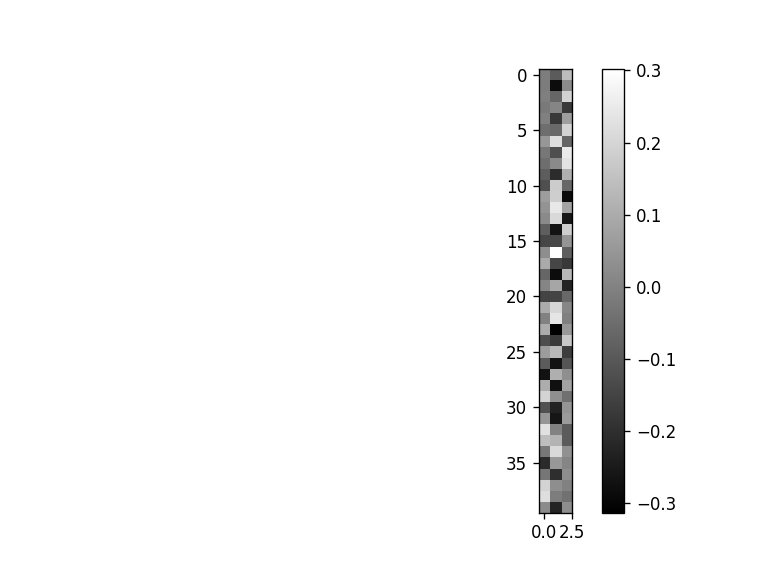

In [5]:
layer_idx = 4
first_layer_weights = model.layers[layer_idx].get_weights()[0].squeeze()
print(first_layer_weights.shape)
plt.figure()
plt.imshow(first_layer_weights.T, cmap='gray')
plt.colorbar()
plt.show()

In [45]:
example_label = 'right'
test_fns = sorted(glob('data/train/audio/%s/*.wav' % example_label))
int2label = get_int2label(wanted_only=False)
num_correct = 0
num_total = len(test_fns)
vis = True
pbar = tqdm(test_fns) if not vis else test_fns
for fn in pbar:
    rate, data = wf.read(fn)
    data = pad_crop(data)
    data = np.float32(data) / 32767
    prediction = model.predict(data.reshape(1, -1)).squeeze()
    label = int2label[prediction.argmax()]
    if label != example_label and vis:
        print("Pred: ", label)
        display(Audio(fn, autoplay=True))
        sleep(1)
    
    if label == example_label:
        num_correct += 1
print("Acc: %.3f" % (float(num_correct) / num_total))

Pred:  _unknown_


Pred:  up


Pred:  on


Pred:  up


Pred:  _unknown_


Pred:  _silence_


Pred:  go


Pred:  on


Pred:  eight


Pred:  three


Pred:  cat


Pred:  six


Pred:  five


Pred:  five


Pred:  _silence_


Pred:  left


Pred:  five


Pred:  one


Pred:  two


Pred:  _unknown_


Pred:  _silence_


Pred:  left


KeyboardInterrupt: 

In [42]:
activation_model = Model(model.input, model.layers[40].output)
print(activation_model.output_shape)

(None, 1, 33, 192)


data/train/audio/stop/56eb74ae_nohash_1.wav
-1.89135 2.91638


<IPython.core.display.Javascript object>


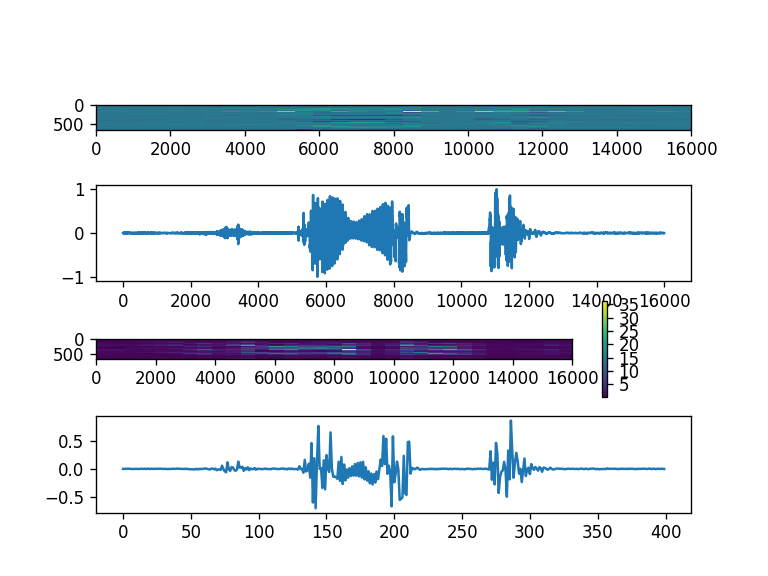

(33, 33)
data/train/audio/stop/3c1e12cf_nohash_1.wav
-0.685057 0.566163


<IPython.core.display.Javascript object>


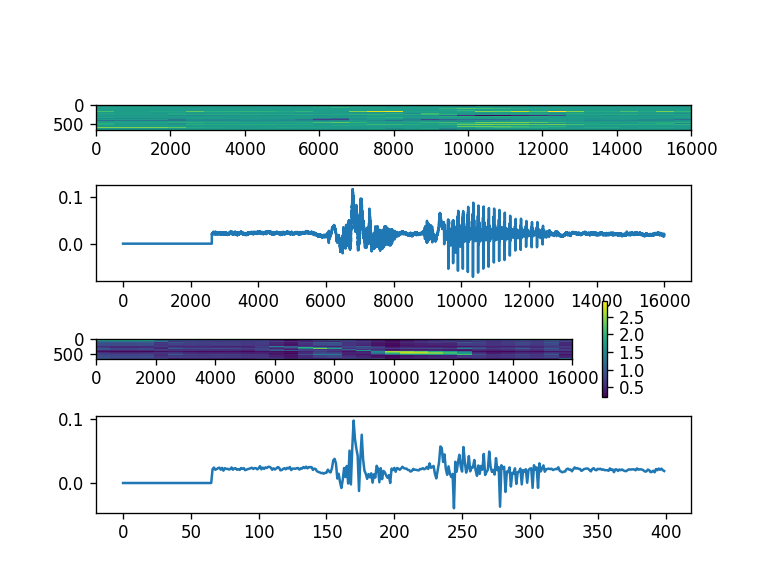

(33, 33)


In [43]:
import cv2
test_fns = sorted(glob('data/train/audio/stop/*.wav'))
int2label = get_int2label(wanted_only=False)
for i in range(2):
    for fn in [test_fns[np.random.randint(len(test_fns))]]:
        print(fn)
        rate, data = wf.read(fn)
        data = pad_crop(data)
        data = np.float32(data) / 32767
        act_val = activation_model.predict(data.reshape(1, -1)).squeeze()
        print(act_val.min(), act_val.max())
        display(Audio(fn, autoplay=True))
        plt.figure()
        plt.subplot(4, 1, 1)
        plt.imshow(cv2.resize(act_val.T, (16000, act_val.shape[0] * 20), interpolation=cv2.INTER_NEAREST))
        plt.subplot(4, 1, 2)
        plt.plot(data)
        plt.subplot(4, 1, 3)
        corr_mat = np.dot(act_val, act_val.T)
        print(corr_mat.shape)
        plt.imshow(cv2.resize(corr_mat, (16000, corr_mat.shape[0] * 20), interpolation=cv2.INTER_NEAREST))
        plt.colorbar()
        plt.subplot(4, 1, 4)
        plt.plot(data[::40])
        plt.show()

In [20]:
a = np.arange(16000)
print(a.reshape((400, 40)))

[[    0     1     2 ...,    37    38    39]
 [   40    41    42 ...,    77    78    79]
 [   80    81    82 ...,   117   118   119]
 ..., 
 [15880 15881 15882 ..., 15917 15918 15919]
 [15920 15921 15922 ..., 15957 15958 15959]
 [15960 15961 15962 ..., 15997 15998 15999]]


# There are a few wrong labels in the training data. Can we find them using ML?

In [5]:
# load best single model
model = my_load_model('checkpoints_086/ep-110-vl-0.1935.hdf5')

In [11]:
train_fns = sorted(glob('data/train/audio/*/*.wav'))
train_fns = [fn for fn in train_fns
             if fn.split('/')[-2] != '_background_noise_' and
             fn.split('/')[-2] != 'unknown_unknown']
print("Found: %d fns" % len(train_fns))

Found: 64721 fns


In [13]:
int2label = get_int2label(wanted_only=False)
fns, preds, gts = [], [], []
for fn in tqdm(train_fns[:]):
    rate, data = wf.read(fn)
    if len(data) != 16000:
        data = pad_crop(data)
    data = np.float32(data) / 32768
    pred = model.predict(data.reshape((1, -1))).squeeze()
    gt_label = fn.split('/')[-2]
    pred_label = int2label[pred.argmax()]
    if pred_label != gt_label:
        fns.append(fn)
        preds.append(pred_label)
        gts.append(gt_label)

pd.DataFrame({'filename': fns,
              'predicted_label': preds,
              'gt_label': gts}).to_csv('wrong_train_labels.csv', index=False)

100%|██████████| 64721/64721 [04:49<00:00, 223.65it/s]


In [15]:
!wc -l wrong_train_labels.csv

1596 wrong_train_labels.csv


In [4]:
wrong_labels = pd.read_csv('wrong_train_labels.csv')
print(wrong_labels.shape)

(1595, 3)


In [10]:
for i in range(wrong_labels.shape[0]):
    fn = wrong_labels.loc[i, 'filename']
    gt = wrong_labels.loc[i, 'gt_label']
    pred = wrong_labels.loc[i, 'predicted_label']
    if gt == 'stop':
        print("%s: GT: %s, PRED: %s" % (fn, gt, pred))
        display(Audio(fn, autoplay=True))
        sleep(1)

data/train/audio/stop/0132a06d_nohash_0.wav: GT: stop, PRED: _silence_


data/train/audio/stop/12529547_nohash_0.wav: GT: stop, PRED: cat


data/train/audio/stop/190821dc_nohash_3.wav: GT: stop, PRED: four


data/train/audio/stop/1fd85ee4_nohash_0.wav: GT: stop, PRED: nine


data/train/audio/stop/28612180_nohash_0.wav: GT: stop, PRED: up


data/train/audio/stop/3f2b358d_nohash_0.wav: GT: stop, PRED: _unknown_


data/train/audio/stop/3f2b358d_nohash_1.wav: GT: stop, PRED: up


data/train/audio/stop/5b09db89_nohash_4.wav: GT: stop, PRED: on


data/train/audio/stop/5fadb538_nohash_0.wav: GT: stop, PRED: up


data/train/audio/stop/5fadb538_nohash_4.wav: GT: stop, PRED: off


data/train/audio/stop/7fd25f7c_nohash_1.wav: GT: stop, PRED: _silence_


data/train/audio/stop/9ff2d2f4_nohash_1.wav: GT: stop, PRED: _unknown_


data/train/audio/stop/aff582a1_nohash_4.wav: GT: stop, PRED: _silence_


data/train/audio/stop/b87bdb22_nohash_0.wav: GT: stop, PRED: _silence_


data/train/audio/stop/b9515bf3_nohash_2.wav: GT: stop, PRED: _silence_


data/train/audio/stop/b959cd0c_nohash_0.wav: GT: stop, PRED: one


data/train/audio/stop/b959cd0c_nohash_2.wav: GT: stop, PRED: off


data/train/audio/stop/b959cd0c_nohash_3.wav: GT: stop, PRED: six


data/train/audio/stop/b959cd0c_nohash_4.wav: GT: stop, PRED: eight


data/train/audio/stop/cc6bae0d_nohash_1.wav: GT: stop, PRED: dog


data/train/audio/stop/ce7a8e92_nohash_1.wav: GT: stop, PRED: _silence_


data/train/audio/stop/ced835d3_nohash_0.wav: GT: stop, PRED: _silence_


data/train/audio/stop/ced835d3_nohash_1.wav: GT: stop, PRED: _silence_


data/train/audio/stop/ced835d3_nohash_2.wav: GT: stop, PRED: up


data/train/audio/stop/ced835d3_nohash_3.wav: GT: stop, PRED: up


data/train/audio/stop/ced835d3_nohash_4.wav: GT: stop, PRED: _silence_


data/train/audio/stop/d9462202_nohash_0.wav: GT: stop, PRED: _silence_


data/train/audio/stop/dbb40d24_nohash_0.wav: GT: stop, PRED: house


data/train/audio/stop/dbb40d24_nohash_1.wav: GT: stop, PRED: up


data/train/audio/stop/dbb40d24_nohash_2.wav: GT: stop, PRED: up


data/train/audio/stop/dbb40d24_nohash_3.wav: GT: stop, PRED: bed


data/train/audio/stop/dbb40d24_nohash_4.wav: GT: stop, PRED: cat


data/train/audio/stop/e96a5020_nohash_0.wav: GT: stop, PRED: _silence_


data/train/audio/stop/e96a5020_nohash_1.wav: GT: stop, PRED: _silence_


data/train/audio/stop/eb3f7d82_nohash_4.wav: GT: stop, PRED: six


data/train/audio/stop/ec201020_nohash_3.wav: GT: stop, PRED: _silence_


data/train/audio/stop/f8f60f59_nohash_0.wav: GT: stop, PRED: six


data/train/audio/stop/f8f60f59_nohash_1.wav: GT: stop, PRED: _silence_


data/train/audio/stop/f9ebdba0_nohash_0.wav: GT: stop, PRED: dog


data/train/audio/stop/f9ebdba0_nohash_1.wav: GT: stop, PRED: dog


data/train/audio/stop/fd395b74_nohash_0.wav: GT: stop, PRED: _silence_


data/train/audio/stop/fd395b74_nohash_1.wav: GT: stop, PRED: _silence_


data/train/audio/stop/fd395b74_nohash_2.wav: GT: stop, PRED: _silence_


data/train/audio/stop/fd395b74_nohash_3.wav: GT: stop, PRED: _silence_


data/train/audio/stop/fd395b74_nohash_4.wav: GT: stop, PRED: _silence_


# Can we speed down the command? This is how I'd repeat something if a person doesn't unterstand me :P (probably louder as well).

In [36]:
train_fns = sorted(glob('data/train/audio/*/*.wav'))
print(len(train_fns))

66301


data/train/audio/stop/21832144_nohash_4.wav


(16000,)


<IPython.core.display.Javascript object>


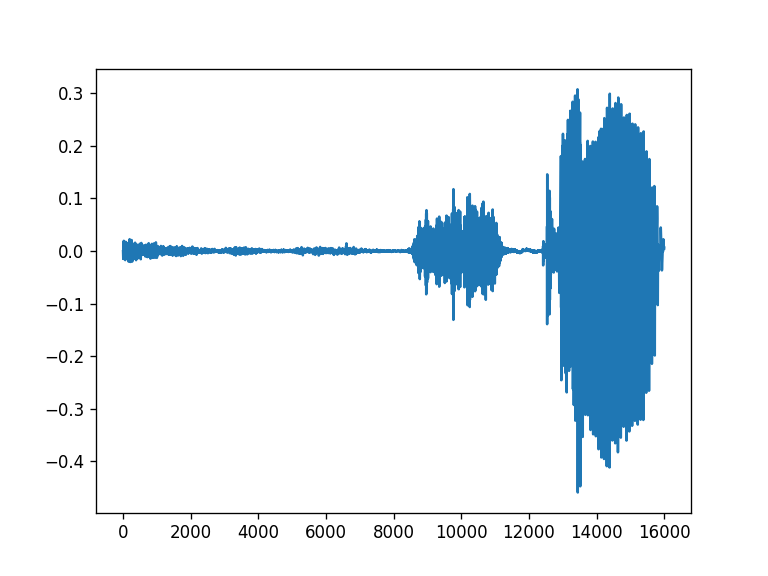

In [46]:
np.random.seed(13)
fn = np.random.choice(train_fns)
print(fn)
rate, data = wf.read(fn)
if len(data) != 16000:
    data = pad_crop(data)
data = np.float32(data) / 32767
float_audio(data, autoplay=True)
print(data.shape)
plt.figure()
plt.plot(data)
plt.show()

20000


<IPython.core.display.Javascript object>


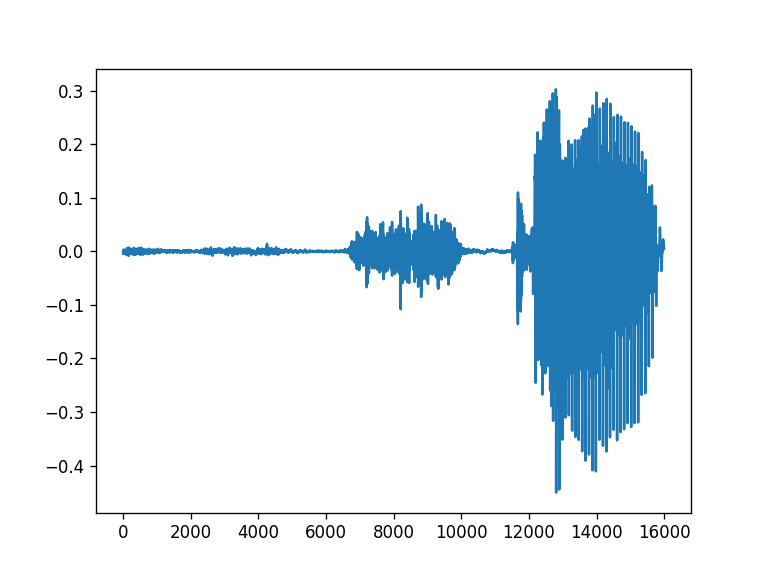

In [48]:
# cv2? lol: https://www.kaggle.com/haqishen/augmentation-methods-for-audio
# The pitch chanes (sounds bad!)
speed_rate = 0.8
w = int(len(data) / speed_rate)
print(w)
data_fast = data.reshape((1, -1))
data_fast = cv2.resize(
    data_fast, (w, 1)).squeeze()
data_fast = data_fast[4000: 20000]
float_audio(data_fast, autoplay=True)
plt.figure()
plt.plot(data_fast)
plt.show()

## Try the same with librosa
### That sounds good!

In [17]:
def center_crop(data, desired_size=16000):
    left = (len(data) - desired_size) // 2
    return data[left: left + desired_size]

(12288,)


<IPython.core.display.Javascript object>


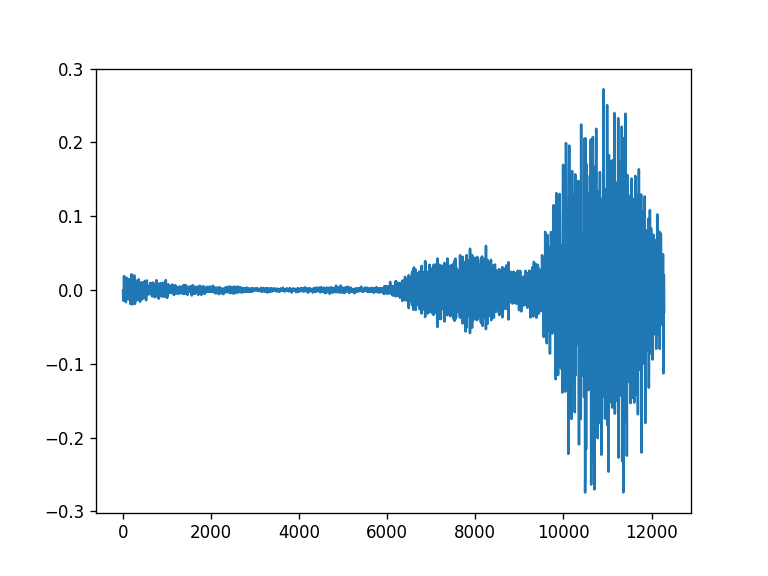

In [53]:
speed = 1.3  # float: < 1.0: slow down, > 1.0: speed up
data_fast = lr.effects.time_stretch(data, speed)
print(data_fast.shape)
# data_fast = data_fast[4000: 20000]
float_audio(data_fast, autoplay=True)
plt.figure()
plt.plot(data_fast)
plt.show()